Load the data:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

confirmed_data = pd.read_csv("/content/sample_data/covid_19_confirmed_v1_lyst1747728690432.csv")
deaths_data = pd.read_csv("/content/sample_data/covid_19_deaths_v1_lyst1747728711771.csv")
recovered_data = pd.read_csv("/content/sample_data/covid_19_recovered_v1_lyst1747728719904.csv")

Checking dtypes and null values:

In [ ]:
confirmed_data.dtypes
confirmed_data.shape
# The confirmed cases dtypes are objects, floats and int for nmber of cases
# Shape = (276 rows, 498 columns)

deaths_data.dtypes
deaths_data.shape
#The deaths cases dtypes are all objects
#Shape = (277 rows, 498 columns)

recovered_data.dtypes
recovered_data.shape
#The recovered cases dtypes are all objects
# Shape = (262 rows, 498 columns)

confirmed_data.isnull().sum()
recovered_data.isnull().sum()
deaths_data.isnull().sum()


,count
Column2,
Afghanistan,1
Albania,1
Algeria,1
Andorra,1
Angola,1
...,...
Vietnam,1
West Bank and Gaza,1
Yemen,1


HANDLING MISSING VALUES

Identifying the missing values and replacing them using a suitable imputation method, such as forward filling, for time-series data.

CONFIRMED CASES DATA MISSING VALUES HANDLING:

In [4]:
confirmed_data_Copy = confirmed_data
confirmed_data_Copy["Province/State"] = confirmed_data_Copy["Province/State"].fillna("All Provinces")
confirmed_data_Copy.isnull().sum()

lat_indexes = confirmed_data_Copy[confirmed_data_Copy["Lat"] == 0].index
long_indexes = confirmed_data_Copy[confirmed_data_Copy["Long"] == 0].index
lat_indexes
long_indexes
confirmed_data_Copy.loc[lat_indexes,"Lat"] = np.nan
confirmed_data_Copy.loc[long_indexes,"Long"] = np.nan
confirmed_data_Copy.isnull().sum()
confirmed_data_Copy[["Lat","Long"]] = confirmed_data_Copy[["Lat", "Long"]].fillna("Unknown")

DEATH CASES MISSING VALUES HANDLING

In [ ]:
deaths_data_copy = deaths_data
new_columns = deaths_data_copy.iloc[0]
old_columns = deaths_data_copy.columns
deaths_data_copy.columns = new_columns
deaths_data_copy = deaths_data_copy[1:]
deaths_data_copy["Province/State"] = deaths_data_copy["Province/State"].fillna("All Provinces")
cases_columns = deaths_data_copy.columns[4:]
cases_columns
deaths_data_copy[cases_columns].isna().sum()
deaths_data_copy[cases_columns] = deaths_data_copy[cases_columns].ffill(axis=1)
deaths_data_copy[cases_columns] = deaths_data_copy[cases_columns].astype(np.int64)
# deaths_data_copy[["Lat","Long"]] = deaths_data_copy[["Lat","Long"]].fillna("Unknown")
lat = deaths_data_copy.groupby("Country/Region")["Lat"].transform(lambda x: x.ffill().bfill())
long = deaths_data_copy.groupby("Country/Region")["Long"].transform(lambda x: x.ffill().bfill())
deaths_data_copy["Lat"] = lat
deaths_data_copy["Long"] = long
deaths_data_copy.isnull().sum()

RRECOVERED CASES MISSING VALUES HANDLING:

In [ ]:
recovered_data_copy = recovered_data
recovered_data_copy.columns = recovered_data_copy.iloc[0]
recovered_data_copy = recovered_data_copy[1:]
recovered_data_copy["Province/State"] = recovered_data_copy["Province/State"].fillna("All Provinces")
cases_columns = recovered_data_copy.columns[4:]
recovered_data_copy[cases_columns] = recovered_data_copy[cases_columns].ffill(axis=1)
recovered_data_copy[cases_columns] = recovered_data_copy[cases_columns].astype(np.int64)
index = recovered_data_copy[recovered_data_copy["Lat"].isna()].index
recovered_data_copy.loc[index,"Lat"] = recovered_data_copy[recovered_data_copy["Country/Region"] =="China"]["Lat"].iloc[0]
recovered_data_copy.loc[index,"Long"] = recovered_data_copy[recovered_data_copy["Country/Region"] =="China"]["Long"].iloc[0]

DATA EXPLORATION

Plot of confirmed cases over time for top 10 countries affected:

In [45]:
def plot_confirmed_cases_over_time(countries, df):
    plt.figure(figsize=(18,10))
    plt.title("Confirmed cases over time in top 10 countries")
    x = df.columns[4:]
    plt.xlabel("Dates")
    for country in countries:
       country_confirmed_cases = df[df["Country/Region"]==country].groupby("Country/Region").sum(numeric_only=True)
       country_confirmed_cases = country_confirmed_cases.transpose()
       country_confirmed_cases.rename(columns={country:"Cases"}, inplace=True)
       y = country_confirmed_cases["Cases"]
       plt.plot(x,y, label= country)
    plt.xticks(x[::30], rotation=90)
    plt.legend()
    plt.savefig("Confirmed_cases_over_time_top_countries.png")
    plt.show()

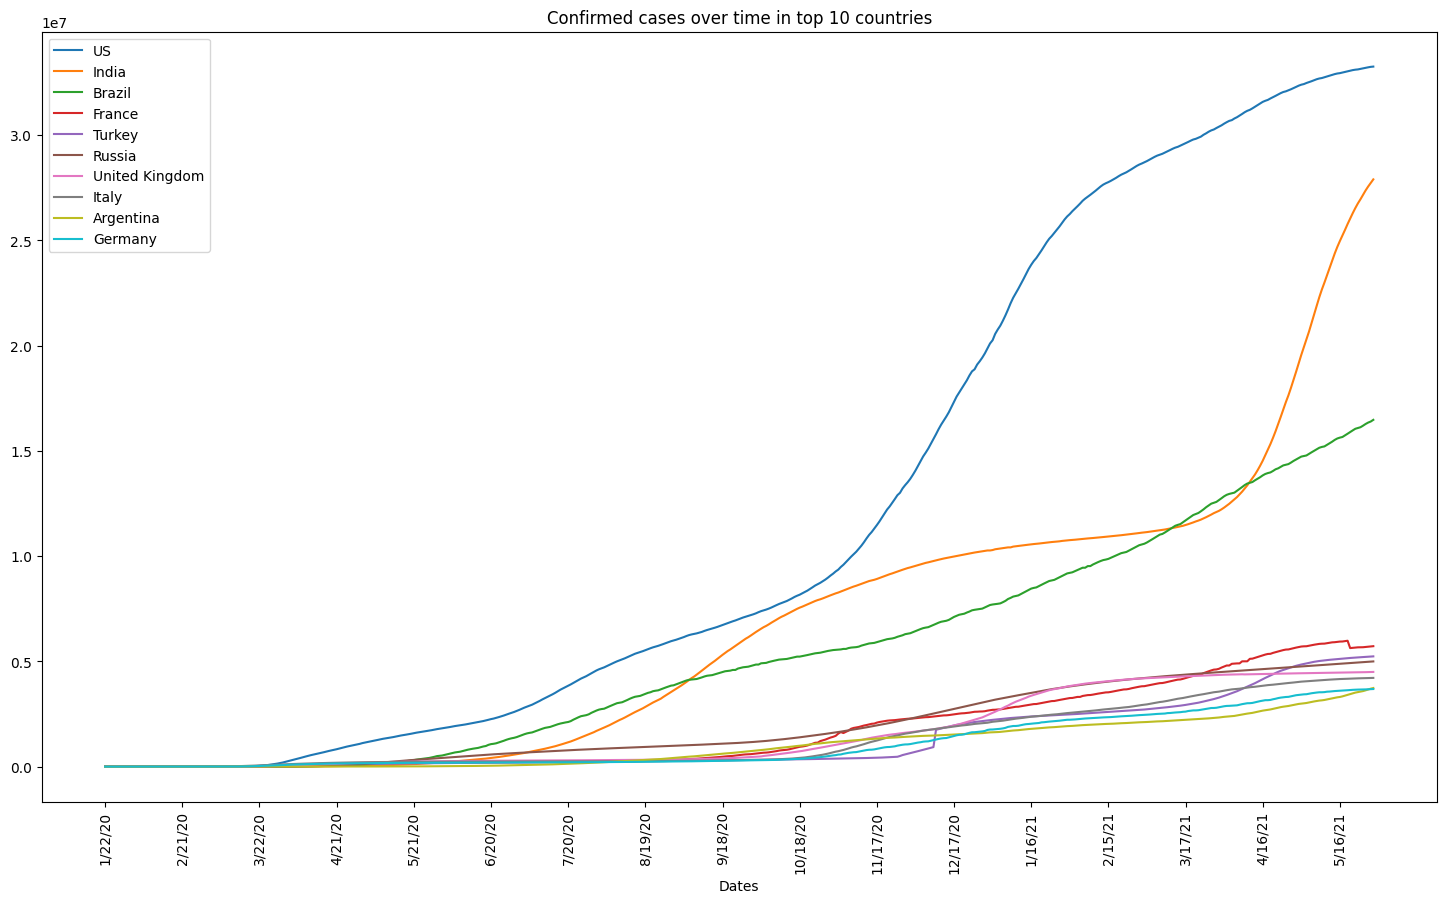

In [46]:
last_index = len(confirmed_data_Copy.columns) -1
last_date = confirmed_data_Copy.columns[last_index]
top_ten_countries = confirmed_data_Copy.sort_values(last_date , ascending=False)["Country/Region"].head(10).values
top_ten_countries

plot_confirmed_cases_over_time(top_ten_countries, confirmed_data_Copy)

 Plot of confirmed cases in China

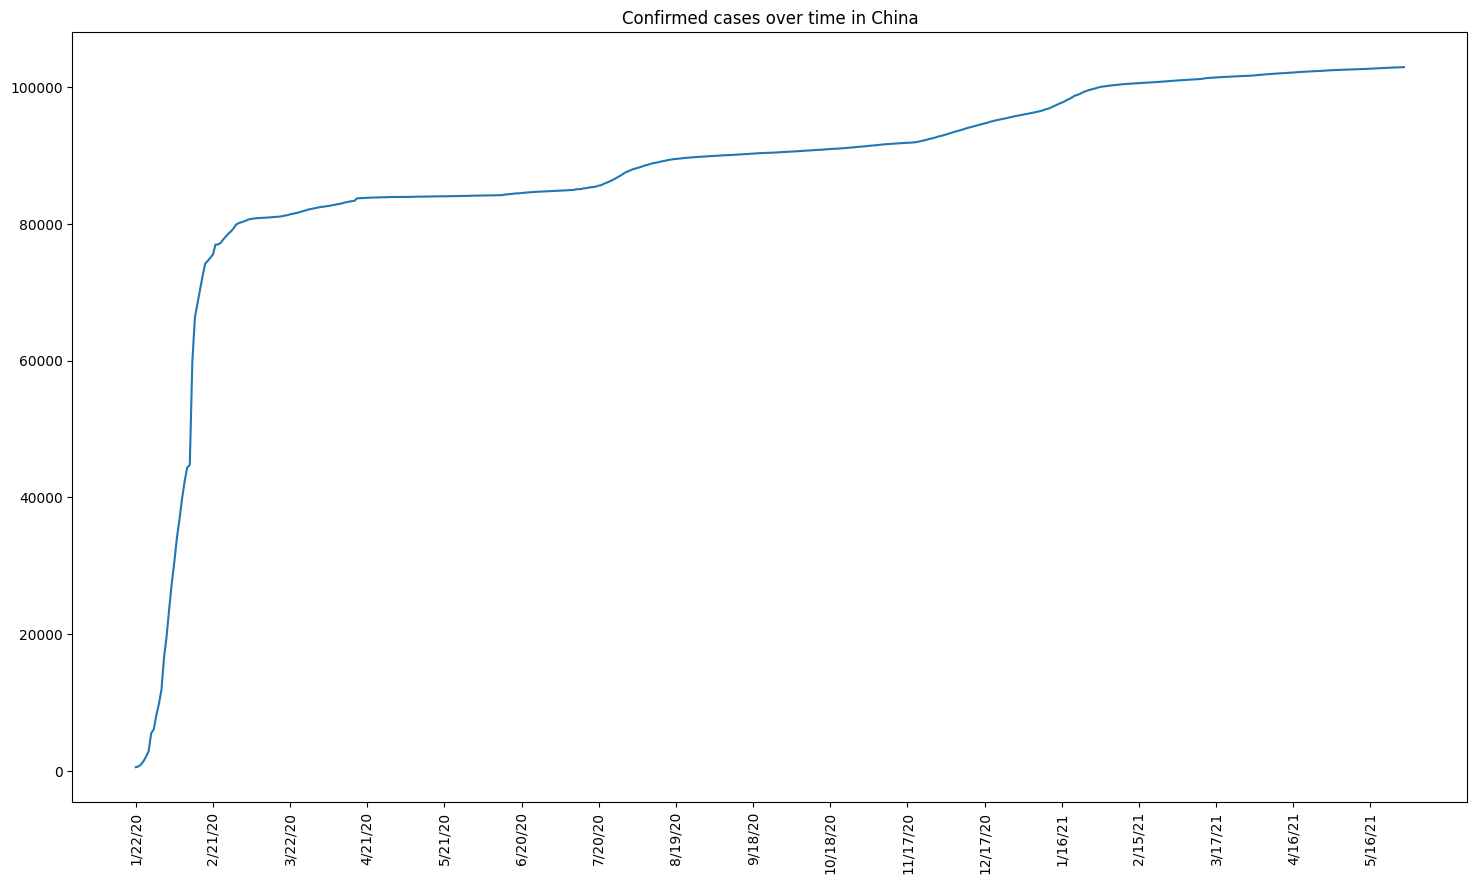

In [21]:
plot_confirmed_cases_over_time(["China"], confirmed_data_Copy)

PROGRESSION OF DAILY NEW CASES FOR TOP 10 COUNTRIES OVER TIME:

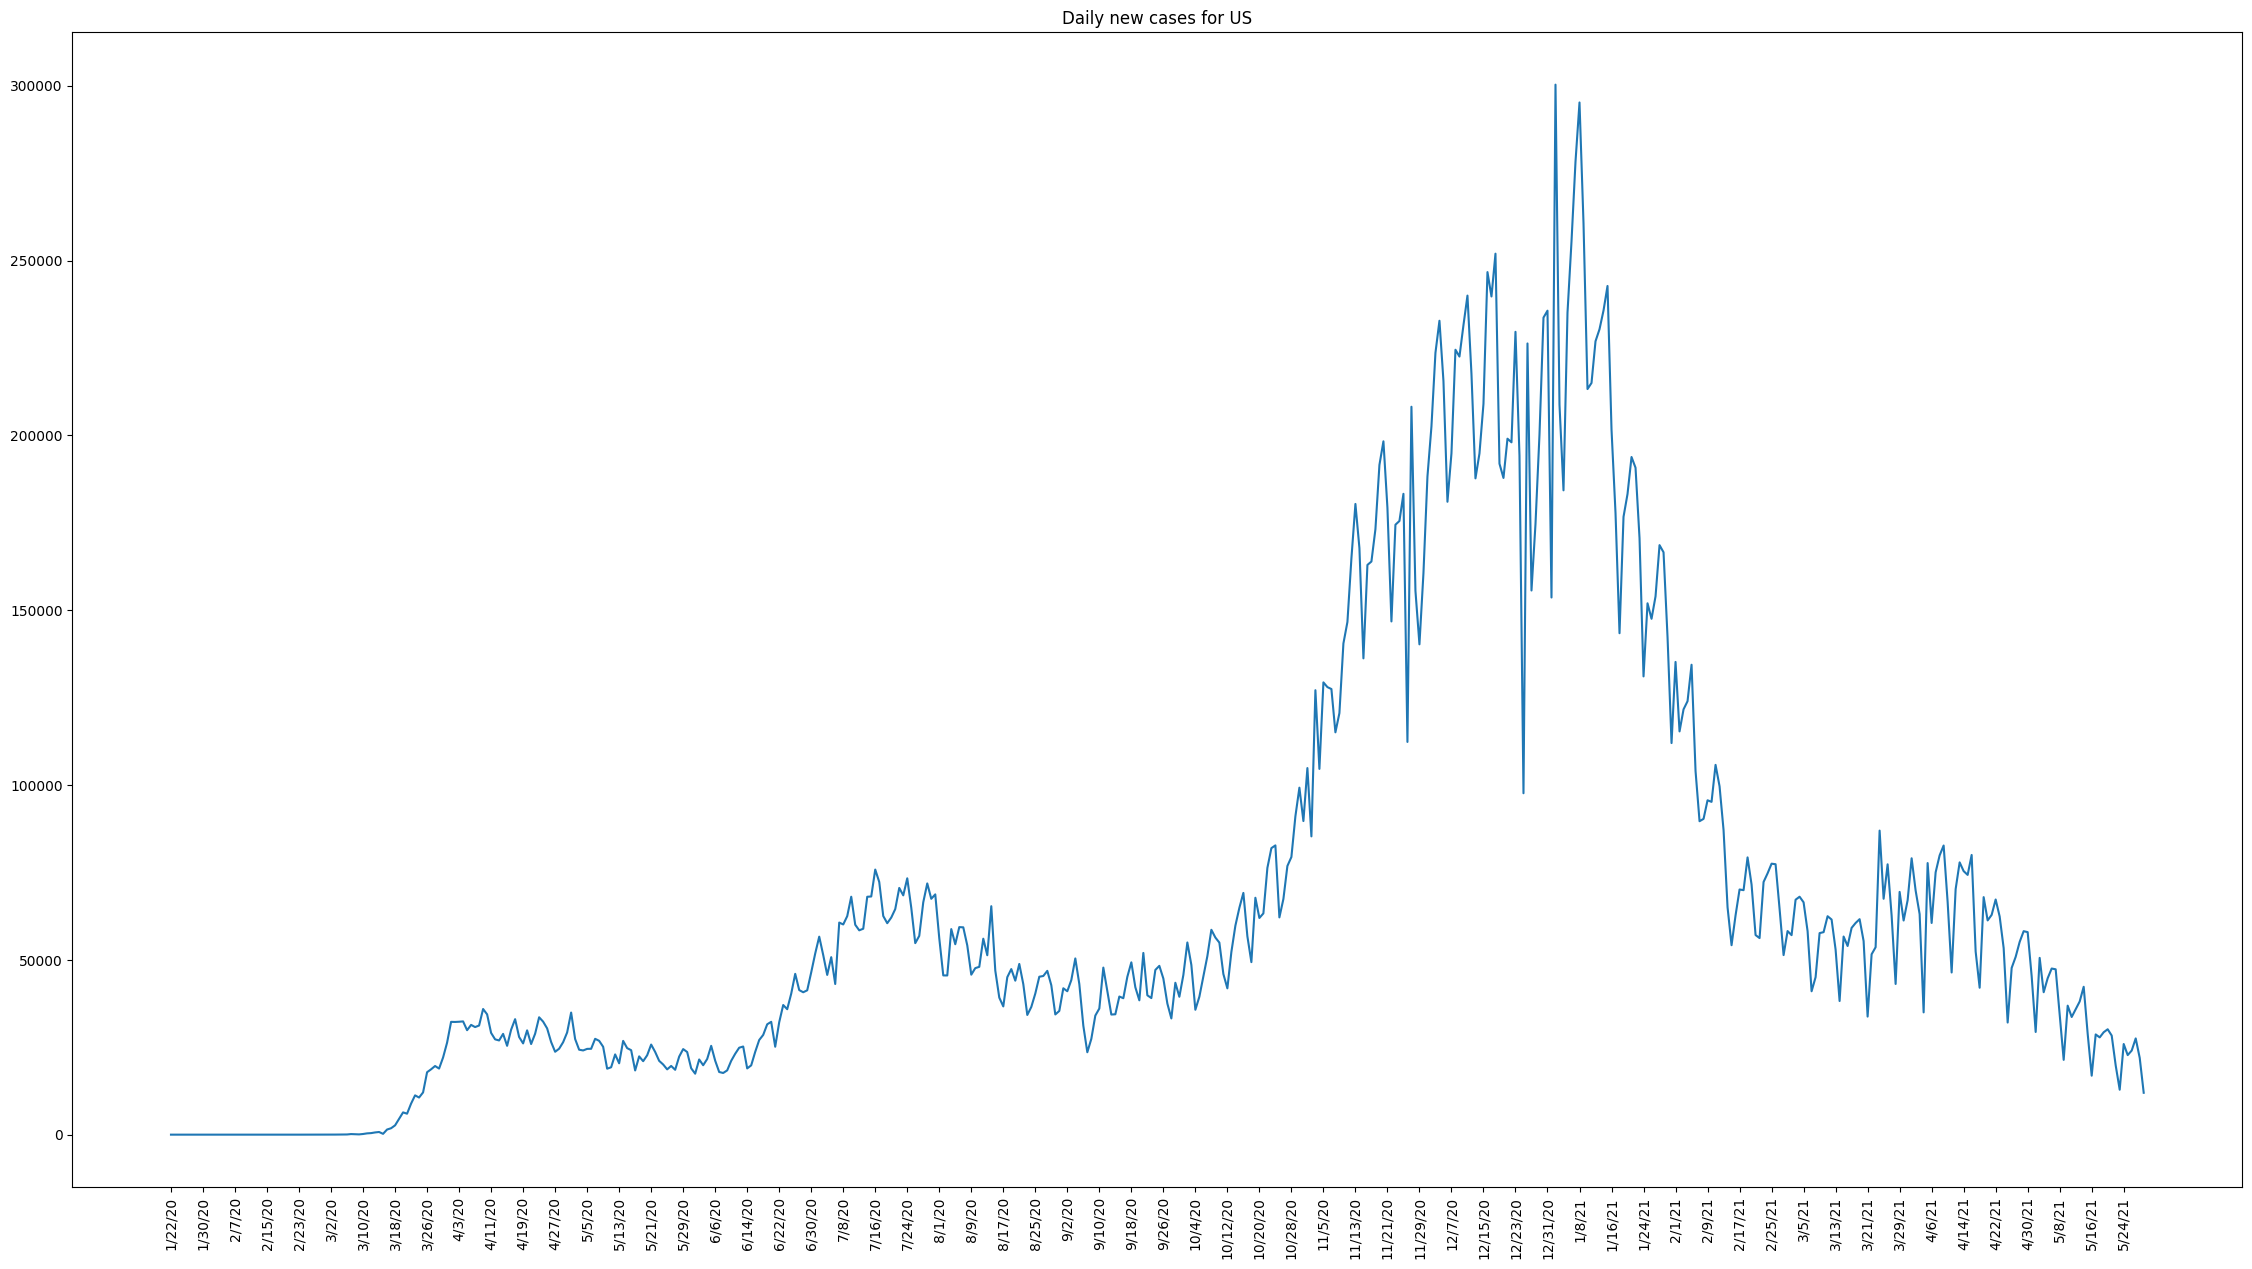

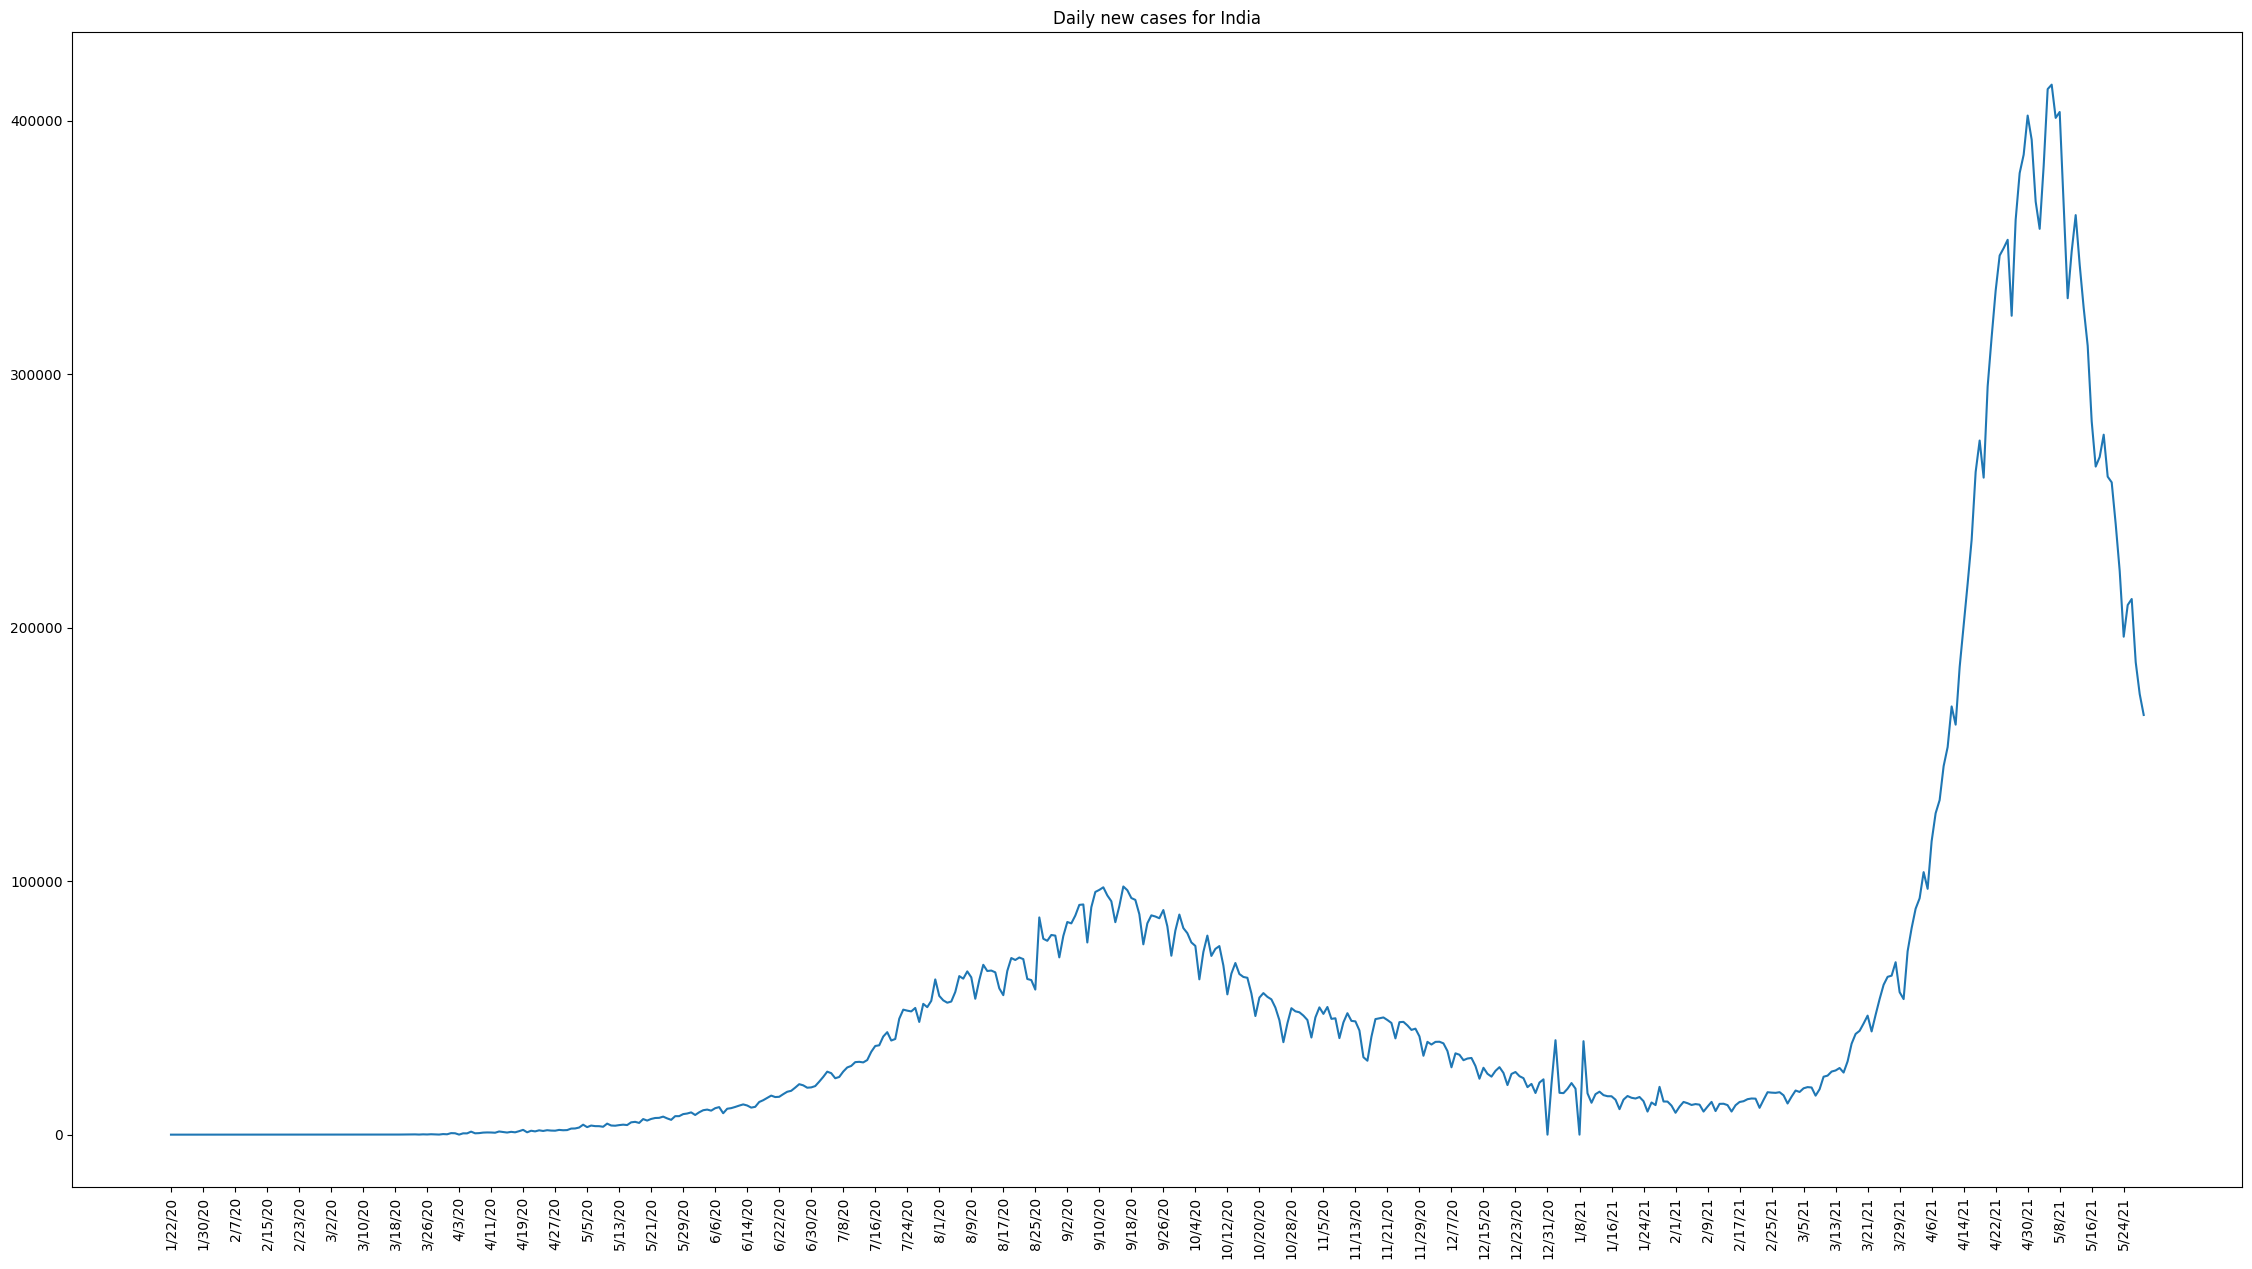

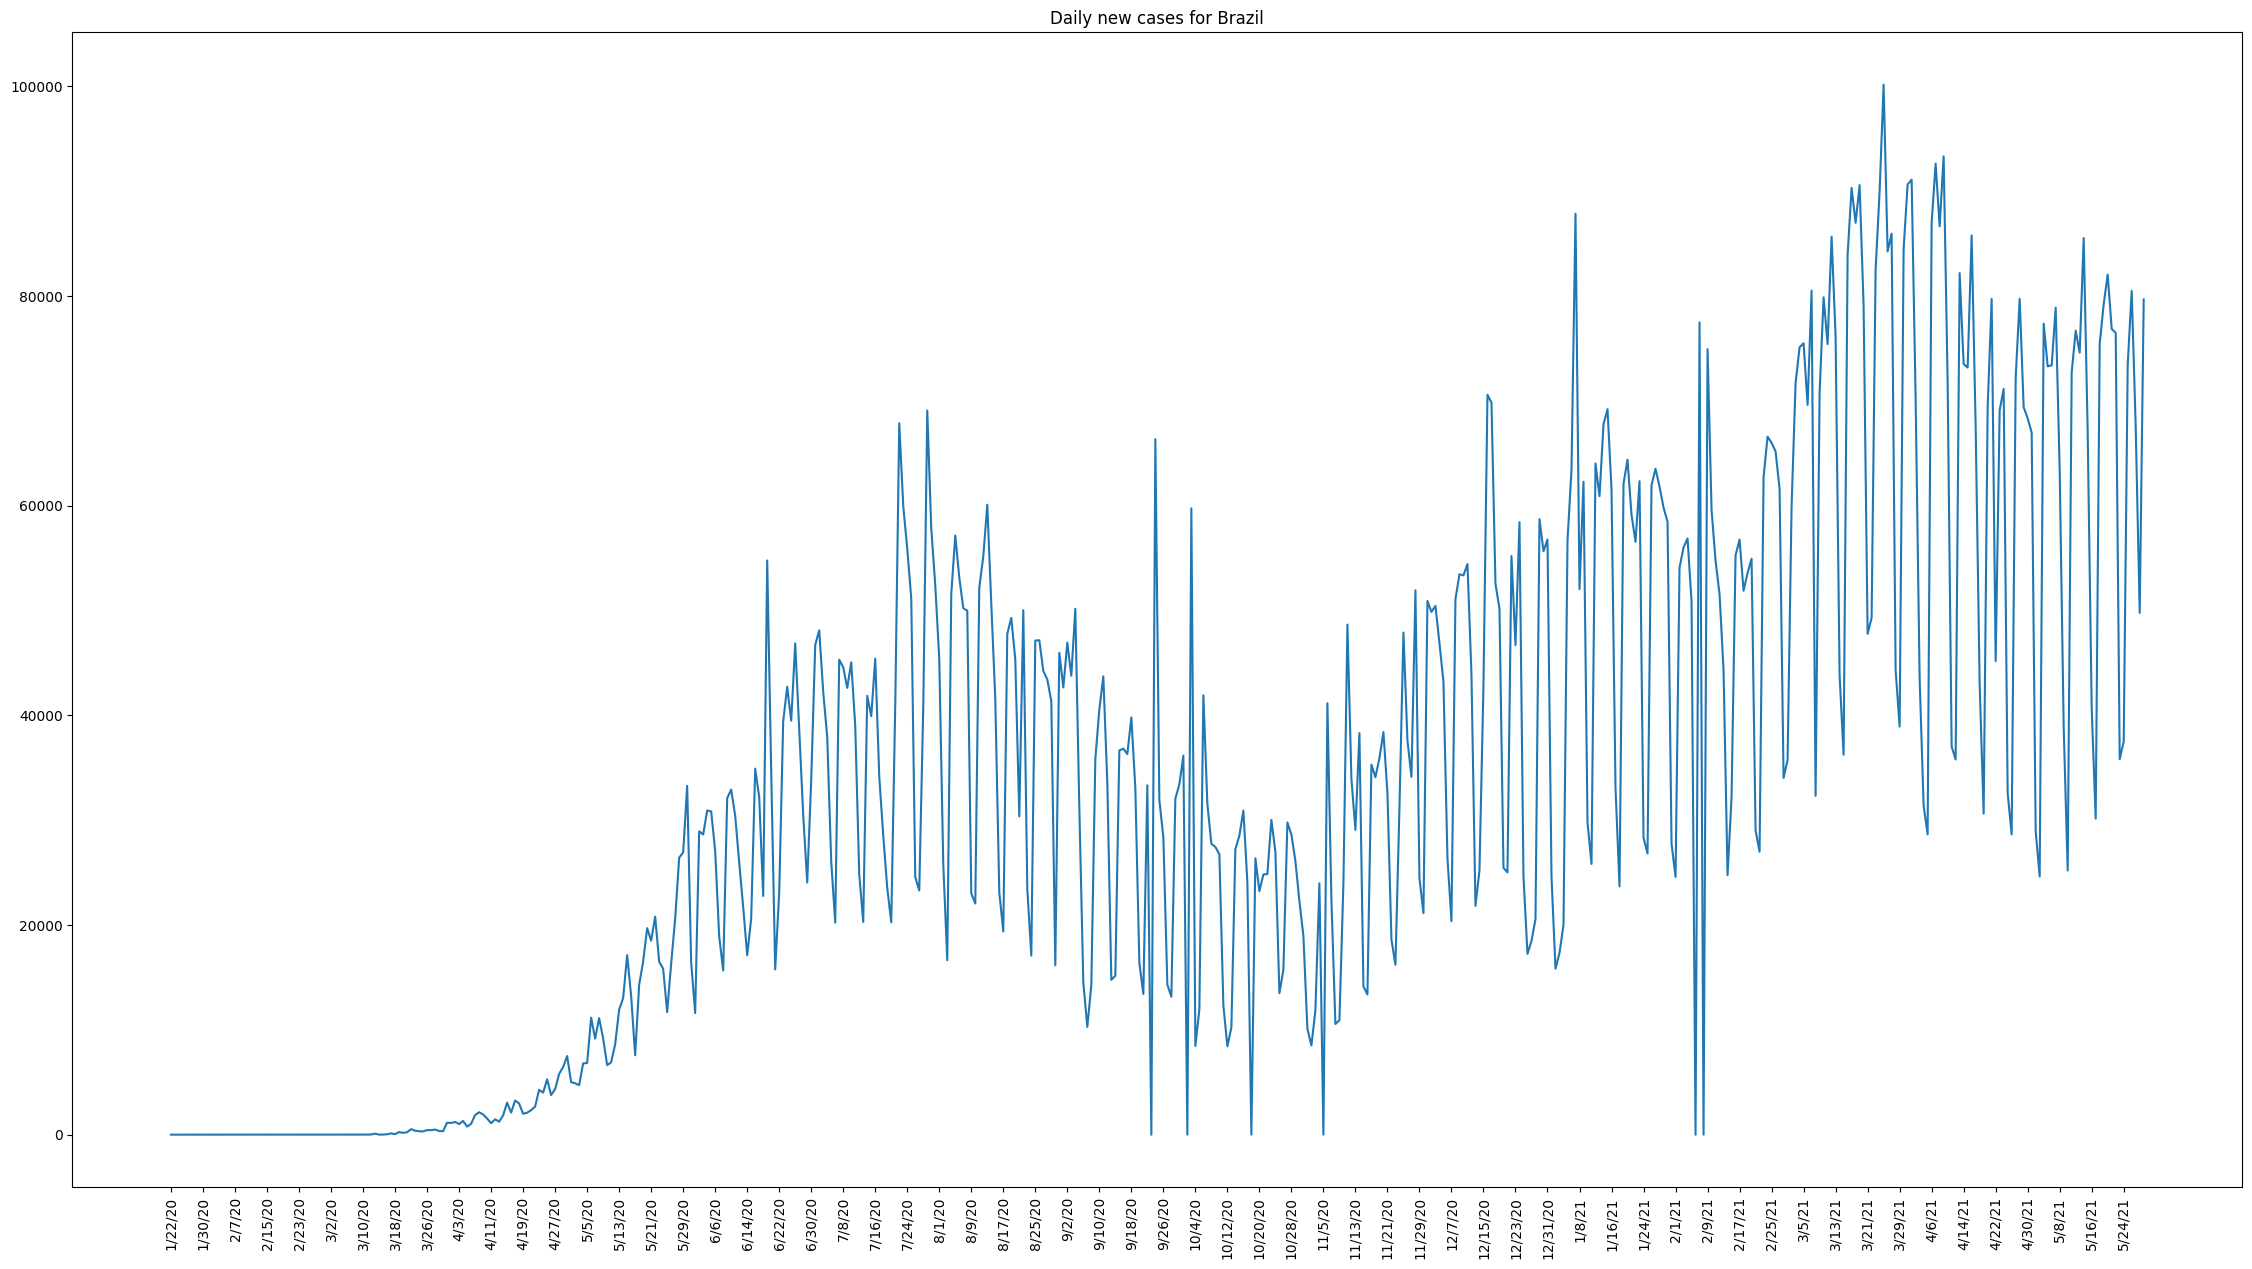

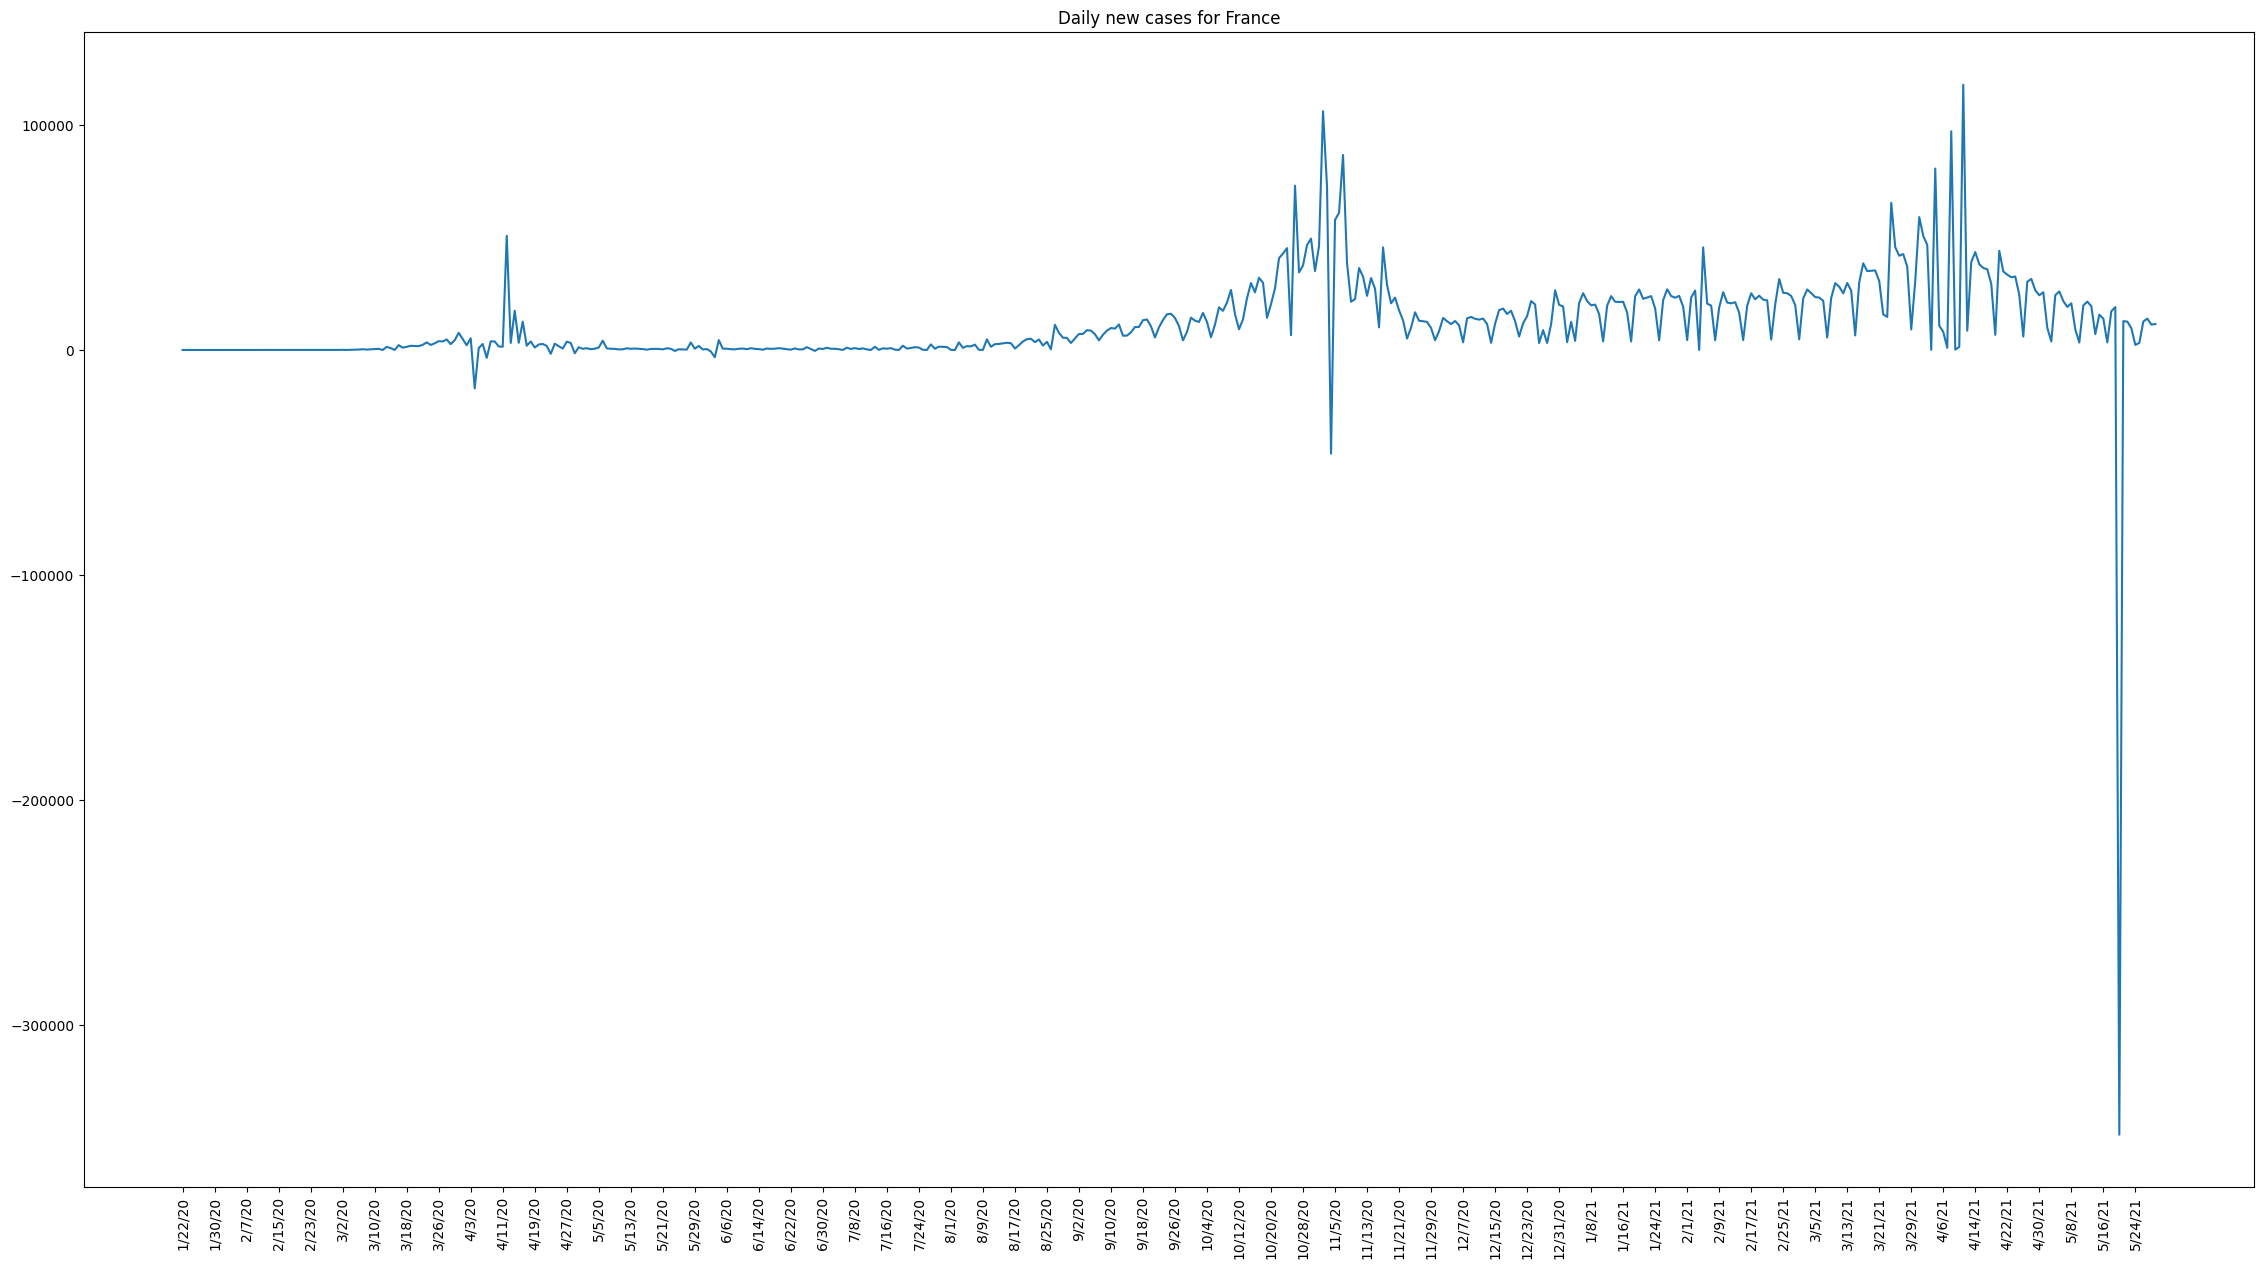

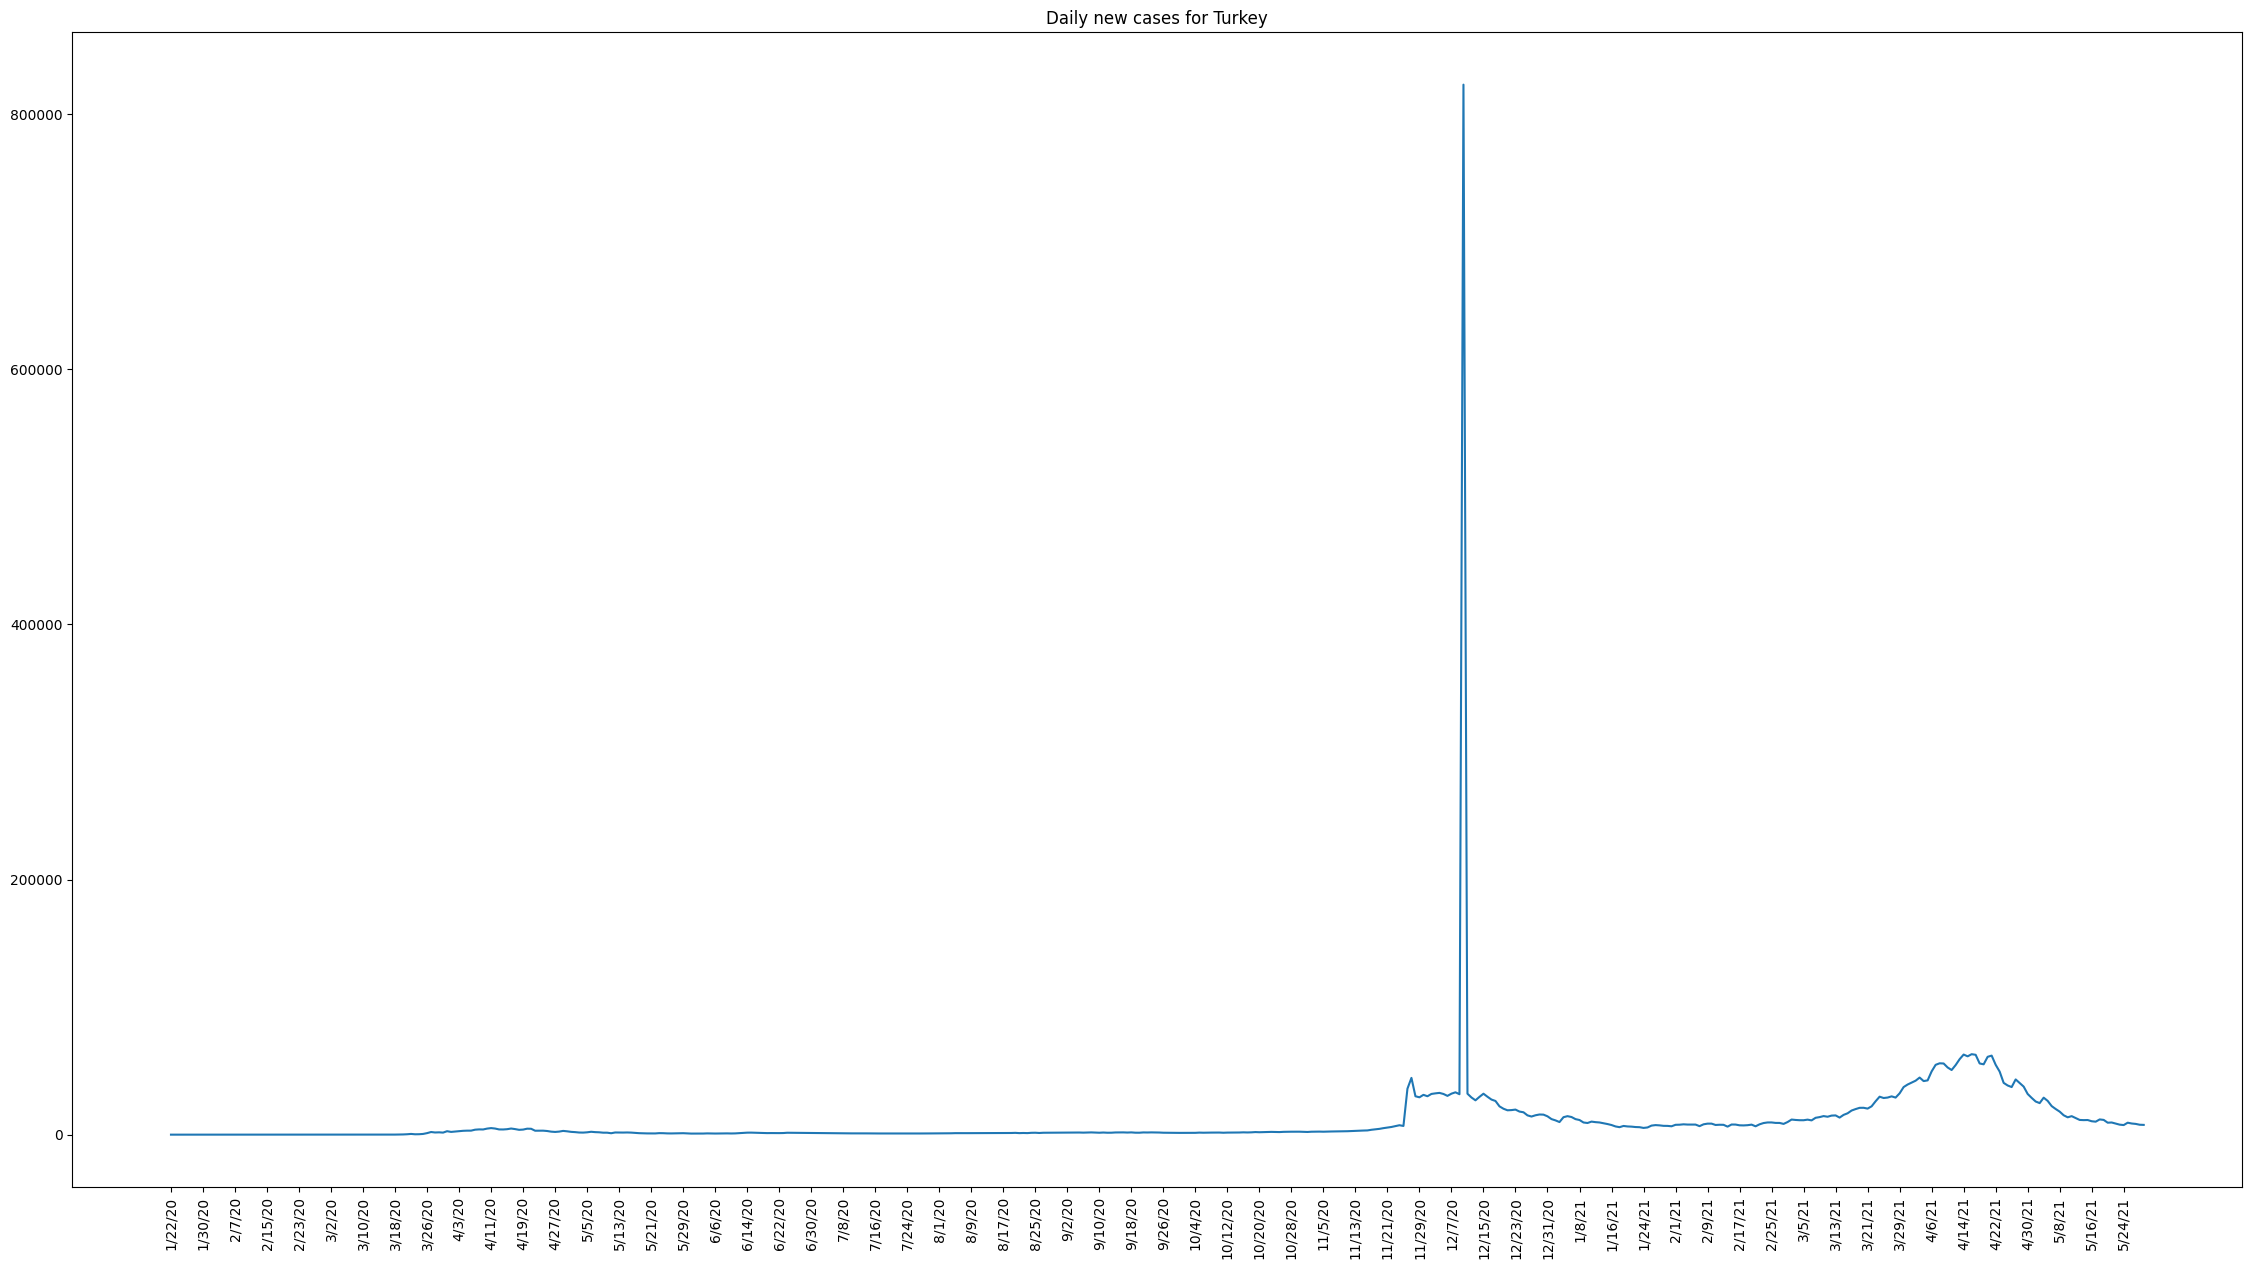

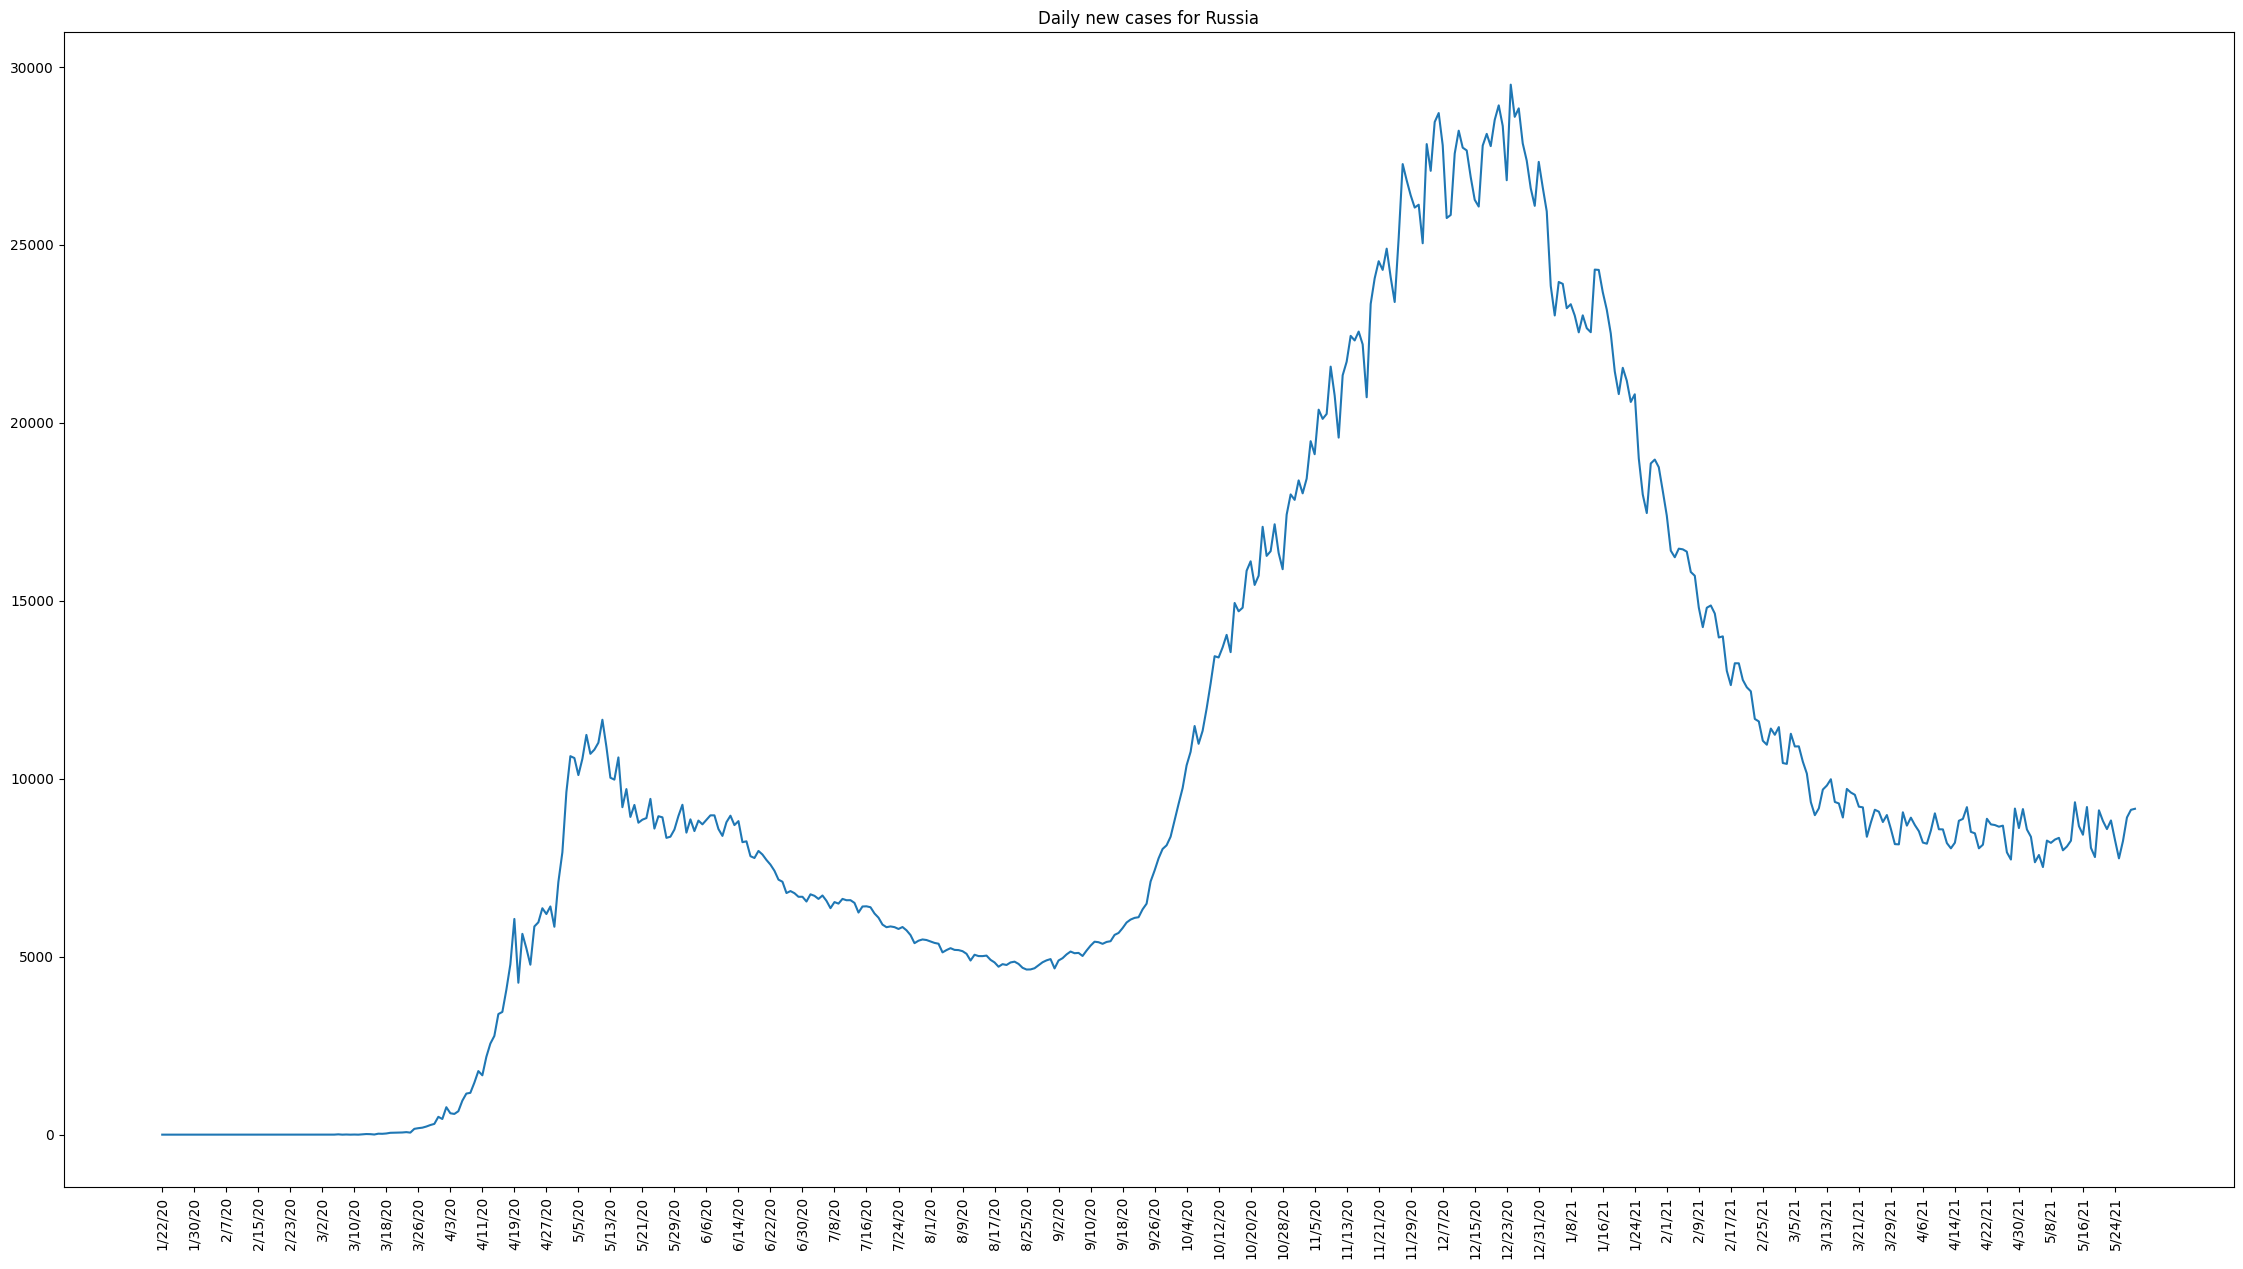

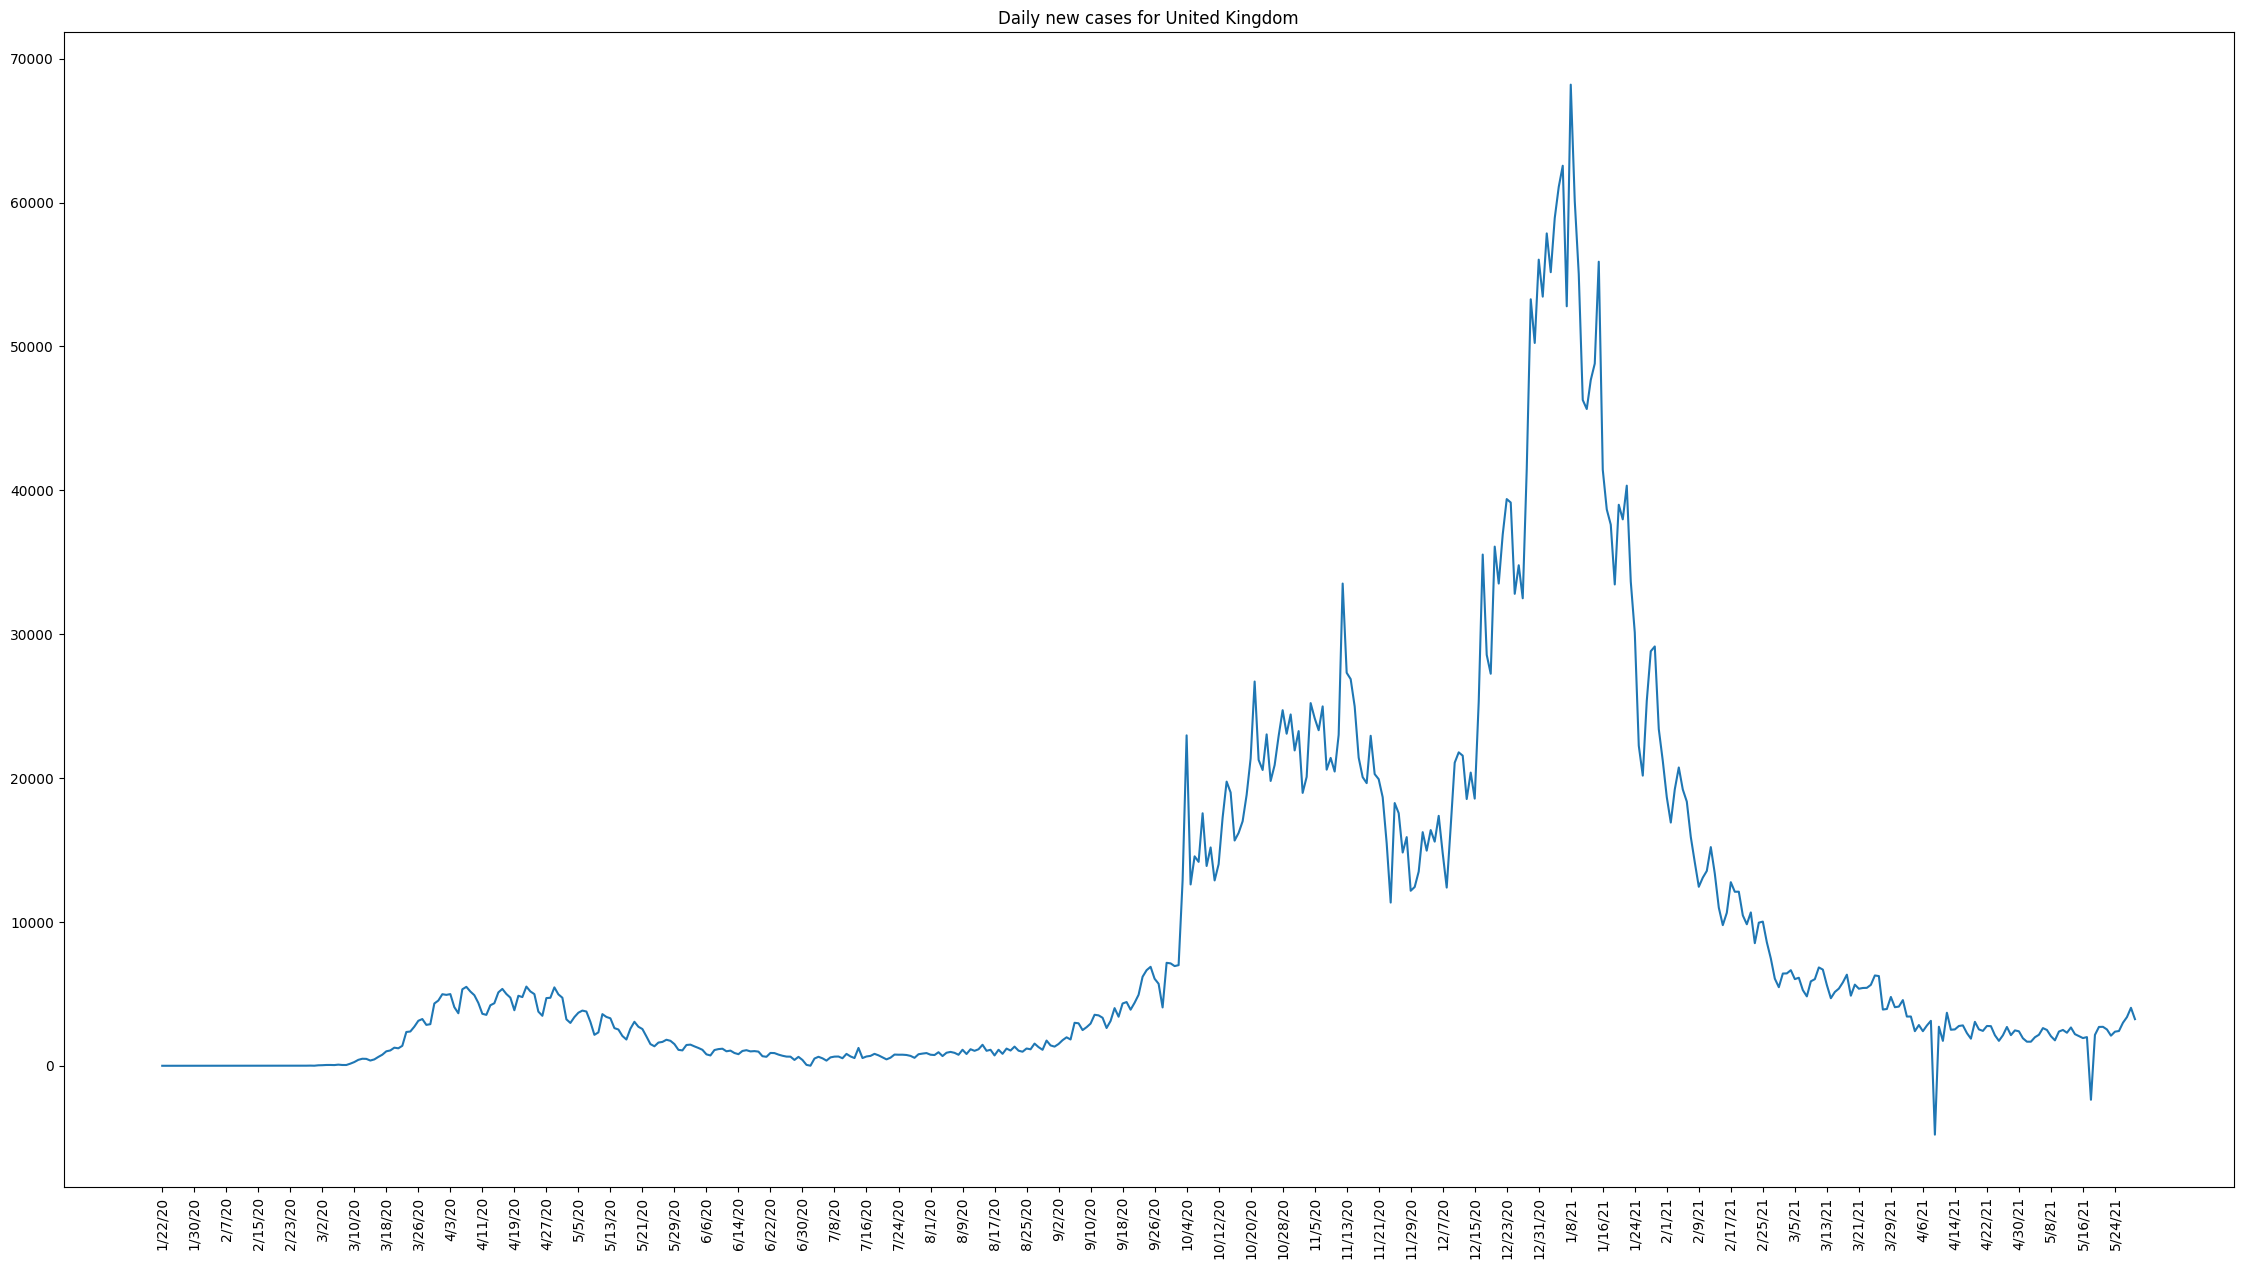

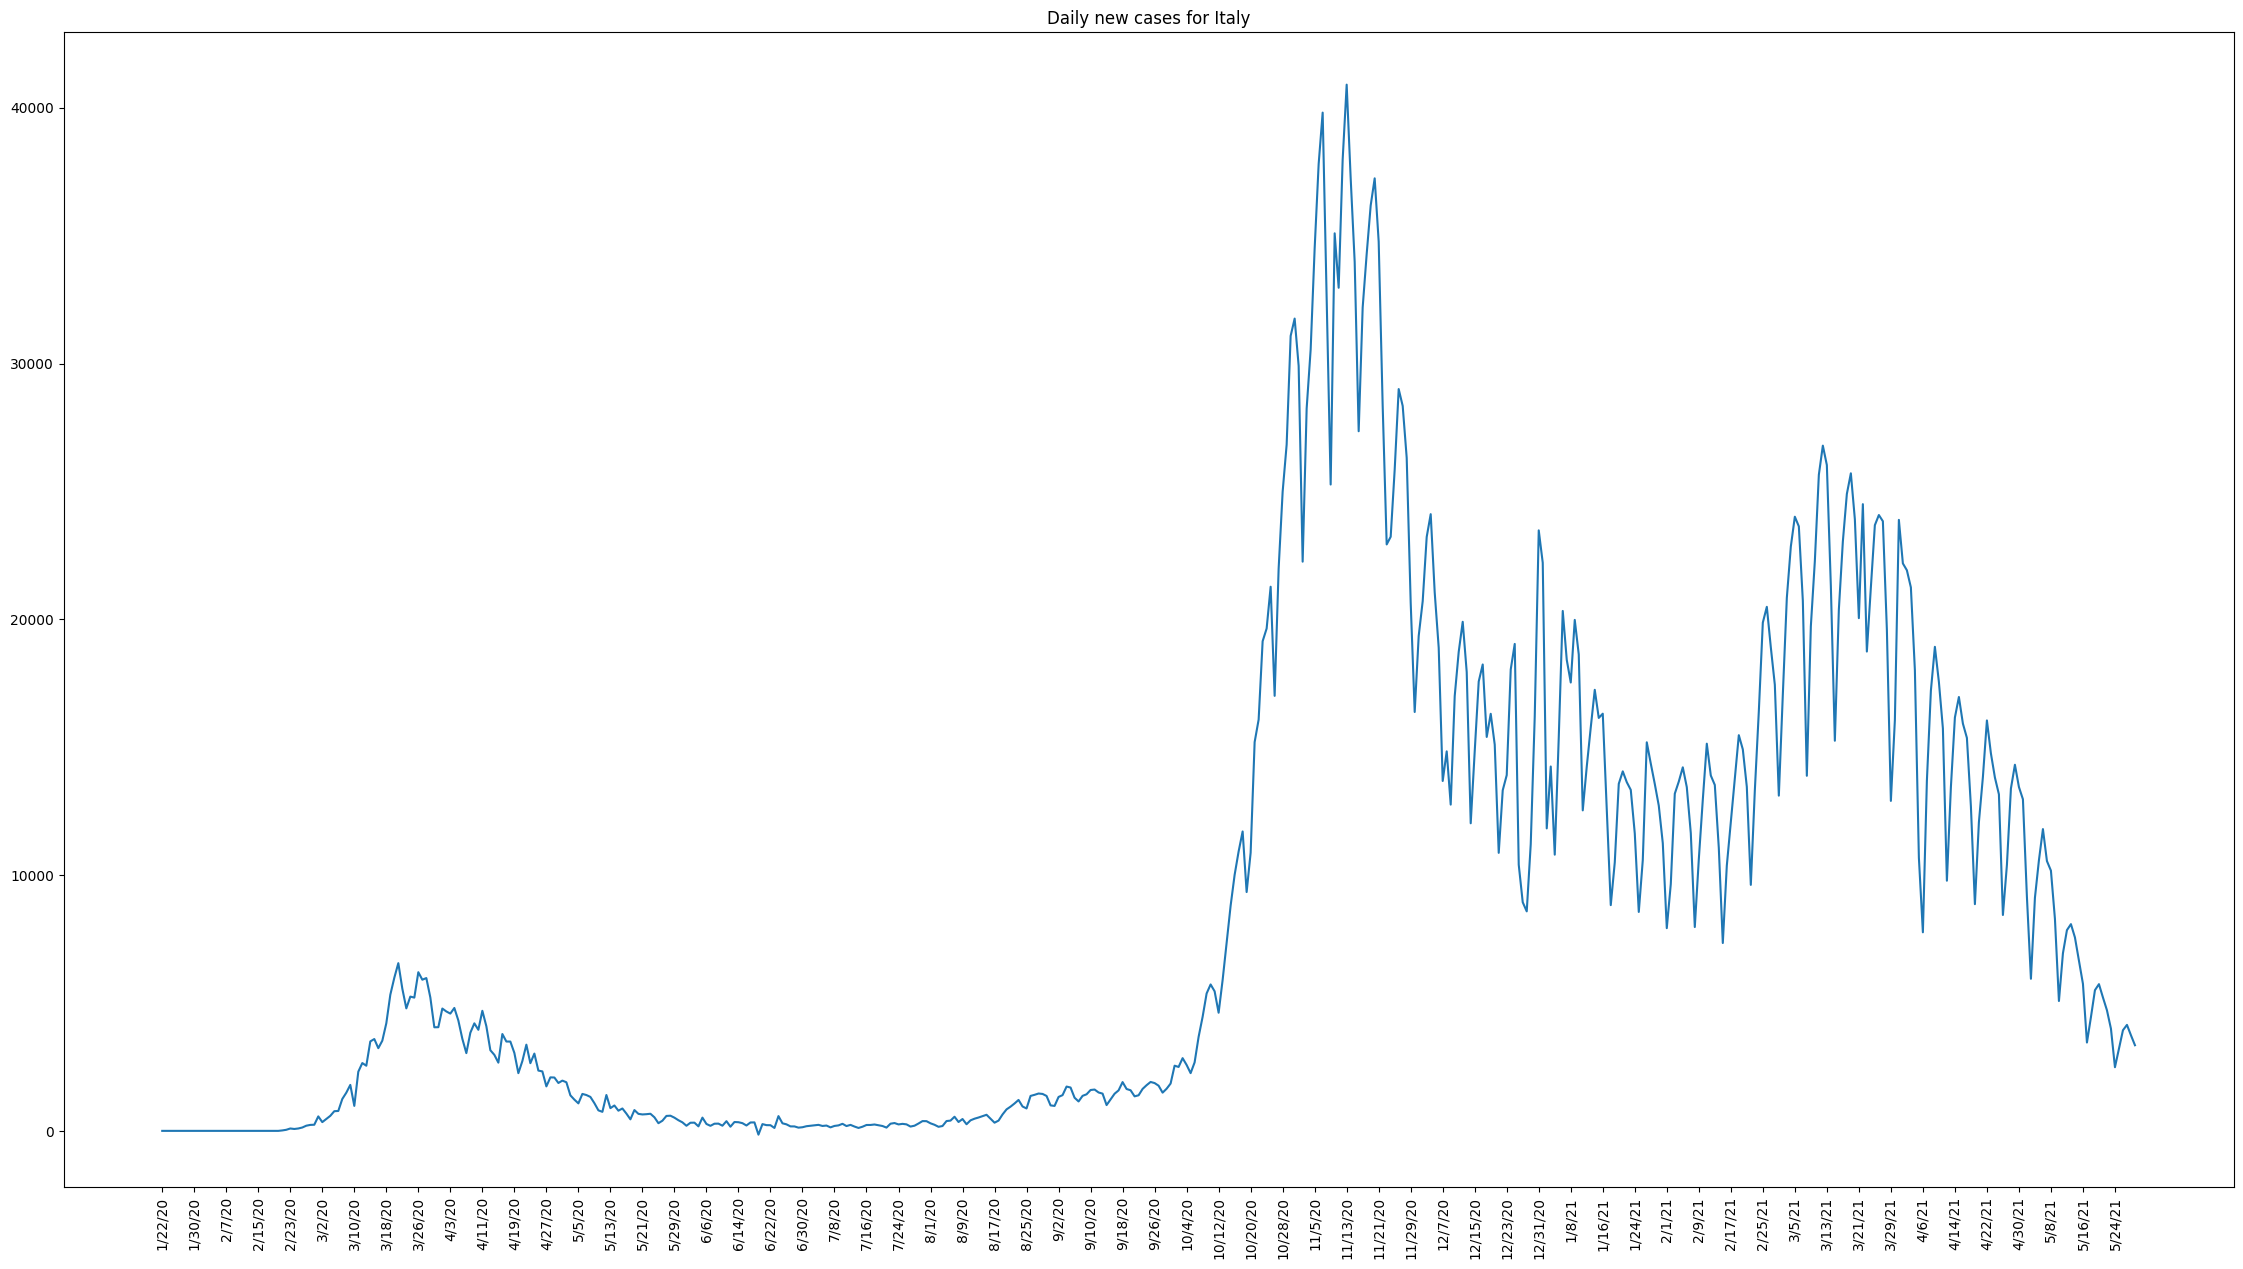

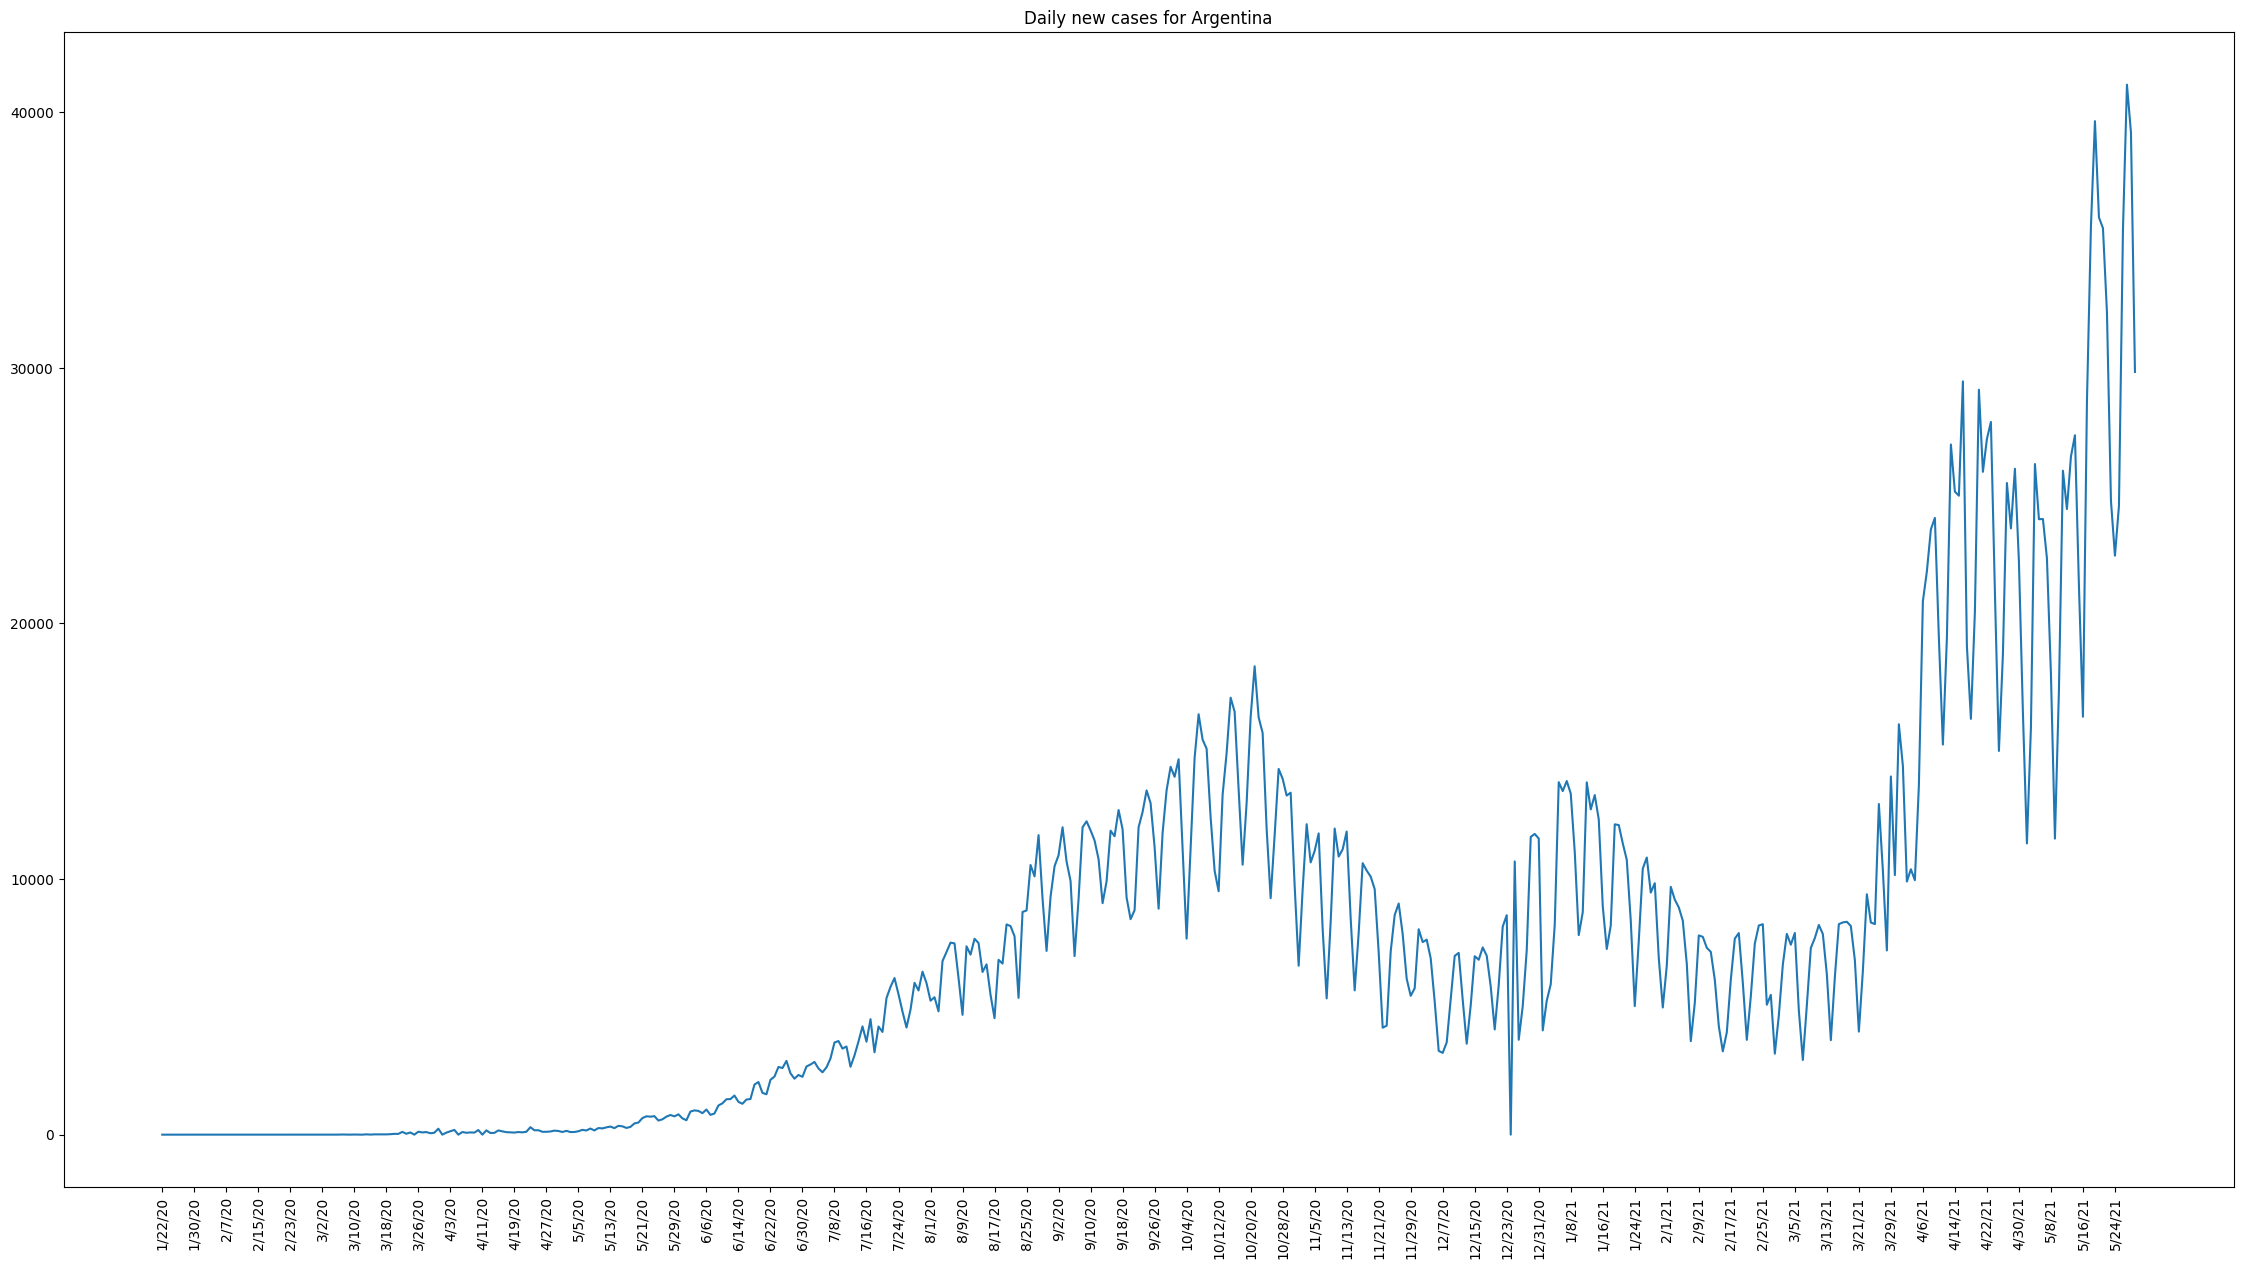

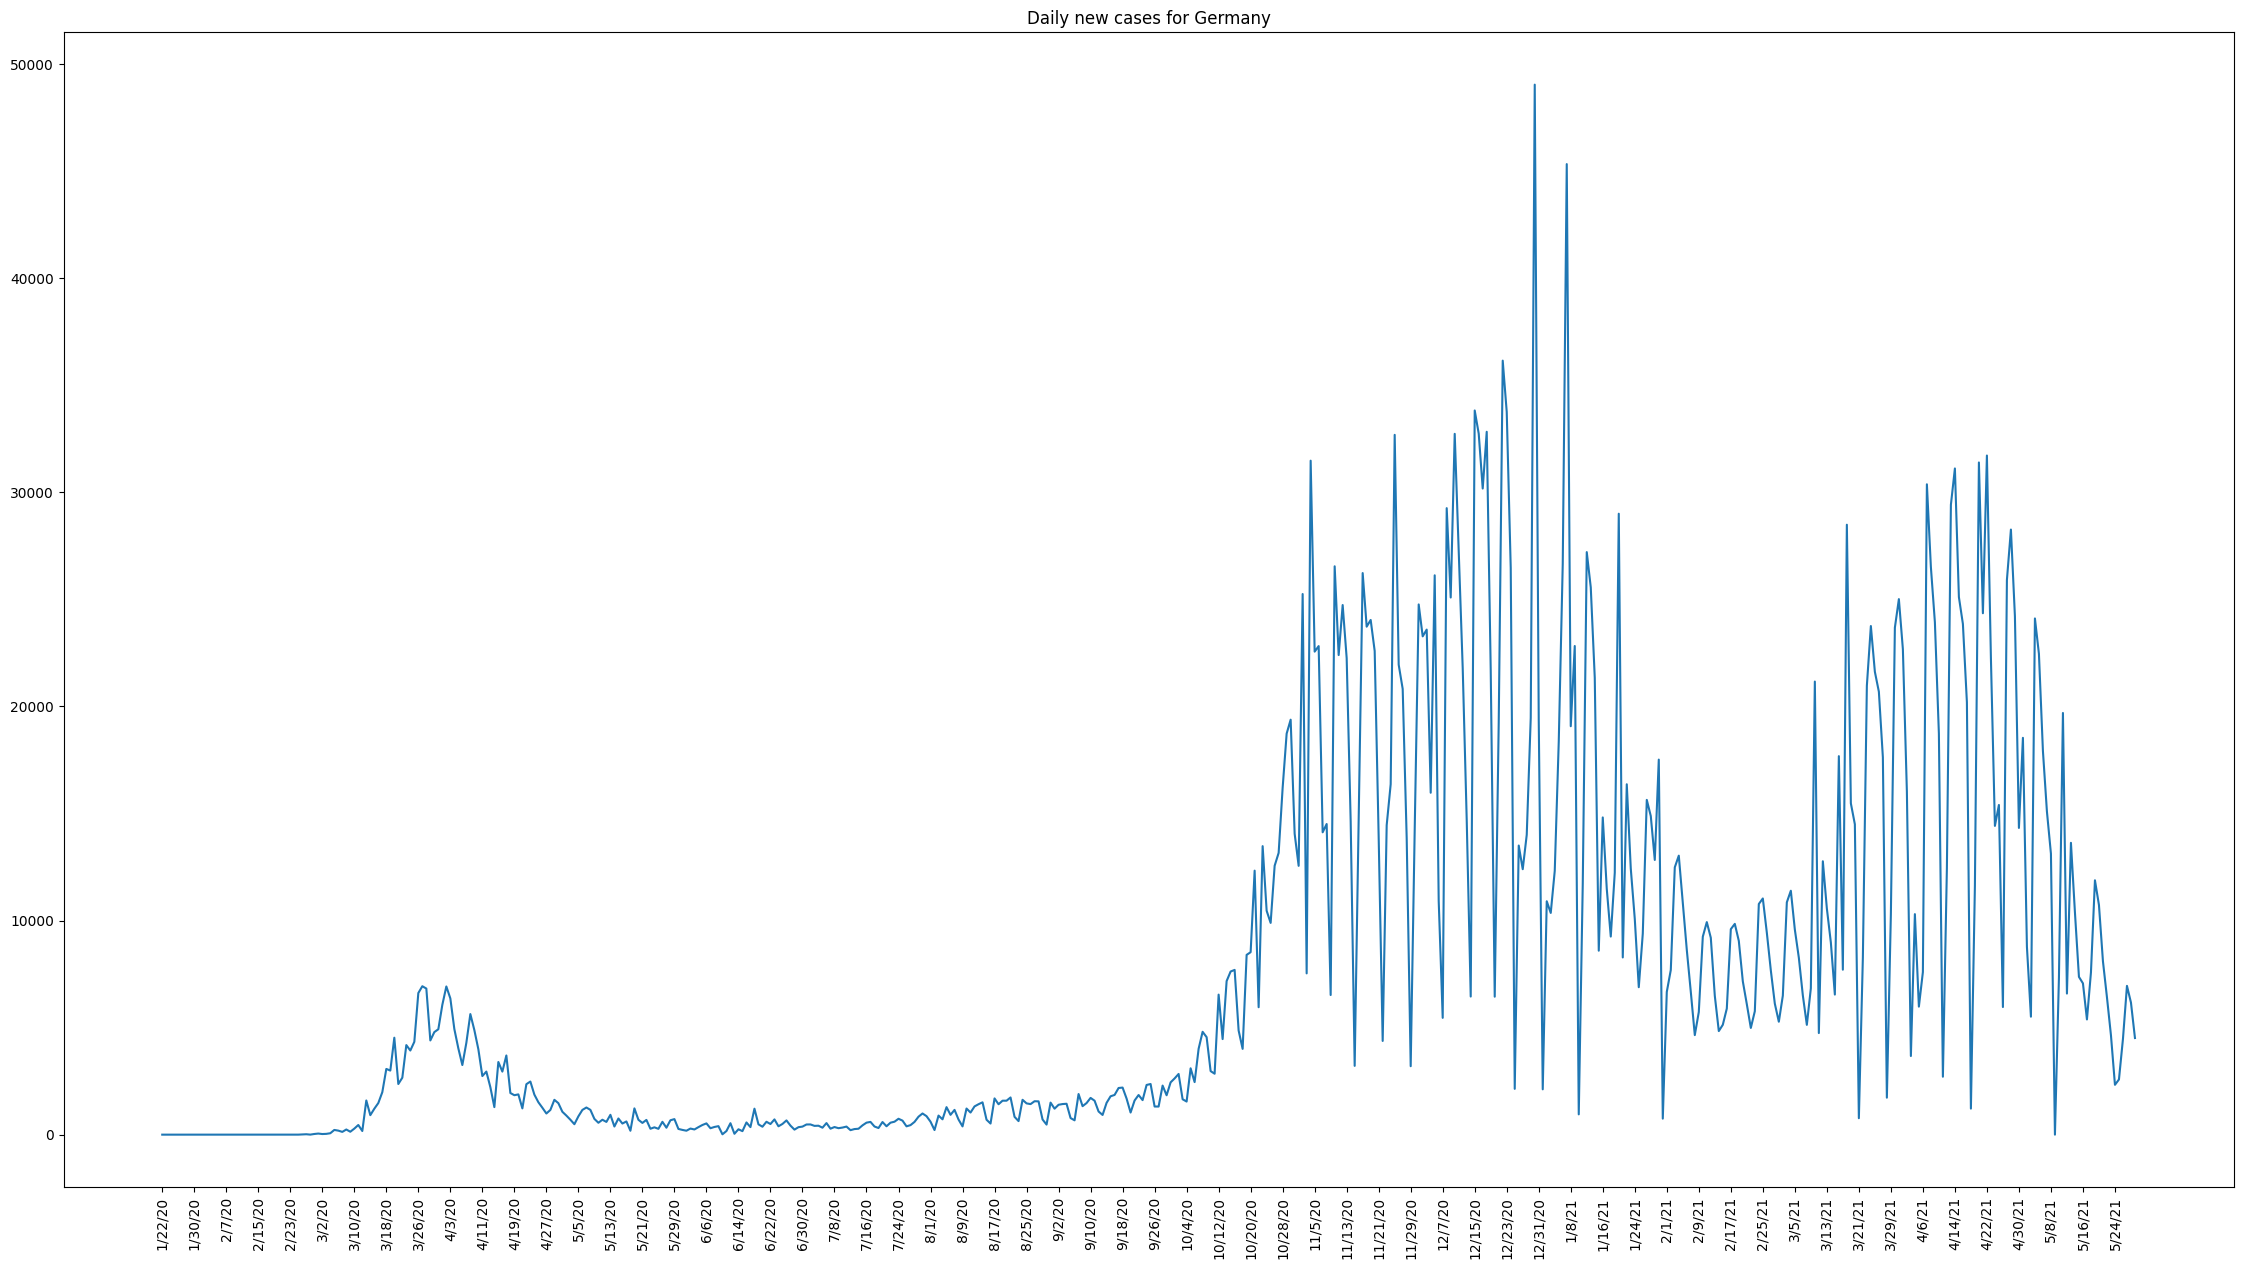

In [72]:
def plot_weekly_new_cases_progression(countries, df):
    for country in countries:
         plt.figure(figsize=(28,15))
         plt.title("Daily new cases for " + country)
         x = df.columns
         y = df.loc[country]
         plt.plot(x,y)
         plt.xticks(x[::8], rotation=90)
         plt.savefig("Daily new cases for " + country + ".png")
         plt.show()

def get_new_cases_for_each_day(df):
    first_column = df[df.columns[0]]
    shifted_df = df.shift(axis=1)
    df = df - shifted_df
    df[first_column.name] = first_column
    return df

grouped_by_country = confirmed_data_Copy.groupby("Country/Region").sum(numeric_only=True)
daily_new_confirmed_cases_data = get_new_cases_for_each_day(grouped_by_country)
plot_weekly_new_cases_progression(top_ten_countries, daily_new_confirmed_cases_data)

INDEPENDENT DATA ANALYSIS:

Q5.1: Analyze the peak number of daily new cases in Germany, France, and Italy. Which country experienced the highest single-day surge, and when did it occur?

In [ ]:
def plot_bar_chart(countries, df):
  for country in countries:
      series = df[country]
      plt.figure(figsize=(20,12))
      plt.title("Daily Cases of "+ country)
      x = series.index
      y = series.values
      peak_date = series.idxmax()
      plt.bar(x, y, label= peak_date )
      plt.xticks(x[::8], rotation=90)
      plt.legend()
      plt.savefig("Daily Cases of "+ country +".svg")
      plt.show()

cases_columns = confirmed_data_Copy.columns[4:]
first_column = cases_columns[0]
first_column_entries = confirmed_data_Copy[first_column]
daily_cases_data = confirmed_data_Copy[cases_columns] - confirmed_data_Copy[cases_columns].shift(axis=1)
daily_cases_data[first_column] = first_column_entries
daily_cases_data[confirmed_data_Copy.columns[:4]] = confirmed_data_Copy[confirmed_data_Copy.columns[:4]]
daily_cases_data = daily_cases_data[daily_cases_data.columns[-4:].to_list() + daily_cases_data.columns[:-4].to_list()]
summed = daily_cases_data.groupby("Country/Region").sum(numeric_only=True).reset_index()
summed_transposed =  summed.transpose()
summed_transposed.columns = summed_transposed.iloc[0]
summed_transposed = summed_transposed[1:]
summed_transposed[summed_transposed <0] = np.nan
summed_transposed.ffill(inplace=True)


<ipython-input-8-b05c01ba6e13>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  summed_transposed.ffill(inplace=True)


Q5.2: Compare the recovery rates (recoveries/confirmed cases) between Canada and Australia as of December 31, 2020. Which country showed better management of the pandemic according to this metric?

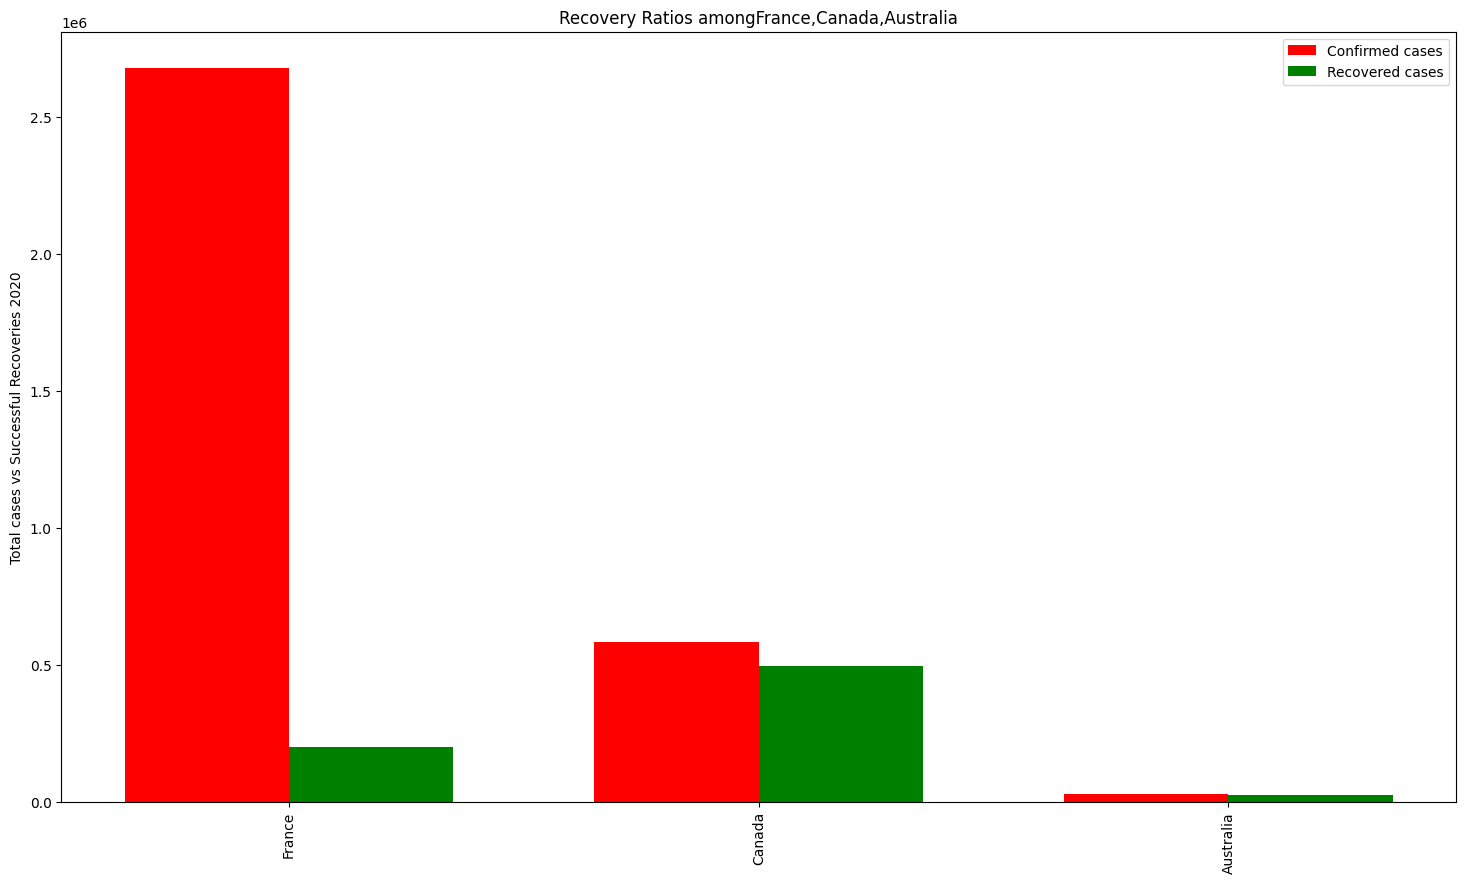

In [ ]:
def compute_ratio(df_numerator, df_denominator, country, as_of_date, by=None):
    total_df_numerator = df_numerator.groupby(by).sum(numeric_only=True).reset_index()
    total_df_denominator = df_denominator.groupby(by).sum(numeric_only=True).reset_index()
    country_numerator = total_df_numerator[total_df_numerator[by]== country][as_of_date]
    country_denominator = total_df_denominator[total_df_denominator[by]==country][as_of_date]
    # return (country_numerator.values[0], country_denominator.values[0], country_numerator.values[0] / country_denominator.values[0] * 100)
    return (country_numerator.values[0], country_denominator.values[0])


def compare_recoveries(countries, cases_df, recoveries_df, as_of_date):
    confirmed_cases = list()
    recovered_cases = list()
    x= np.arange(len(countries))
    width= 0.35
    for country in countries:
        recovery_ratio = compute_ratio(recoveries_df, cases_df, country, as_of_date, by="Country/Region")
        confirmed_cases.append(recovery_ratio[1])
        recovered_cases.append(recovery_ratio[0])
    plt.figure(figsize=(18,10))
    plt.title("Recovery Ratios among" + ",".join(countries))
    plt.ylabel("Total cases vs Successful Recoveries 2020")
    plt.bar(x-width/2, confirmed_cases, width, label= "Confirmed cases" , color="red" )
    plt.bar(x+width/2, recovered_cases, width, label="Recovered cases", color="green")
    plt.xticks(x, countries, rotation=90)
    plt.legend()
    plt.savefig("Recovery Ratios among " + ", ".join(countries) +" 2020.png")
    plt.show()


end_of_2020 = "12/31/20"
compare_recoveries(["France", "Canada", "Australia"], confirmed_data_Copy, recovered_data_copy, end_of_2020)

Q5.3: What is the distribution of death rates (deaths/confirmed cases) among provinces in Canada? Identify the province with the highest and lowest death rate as of the latest data point.

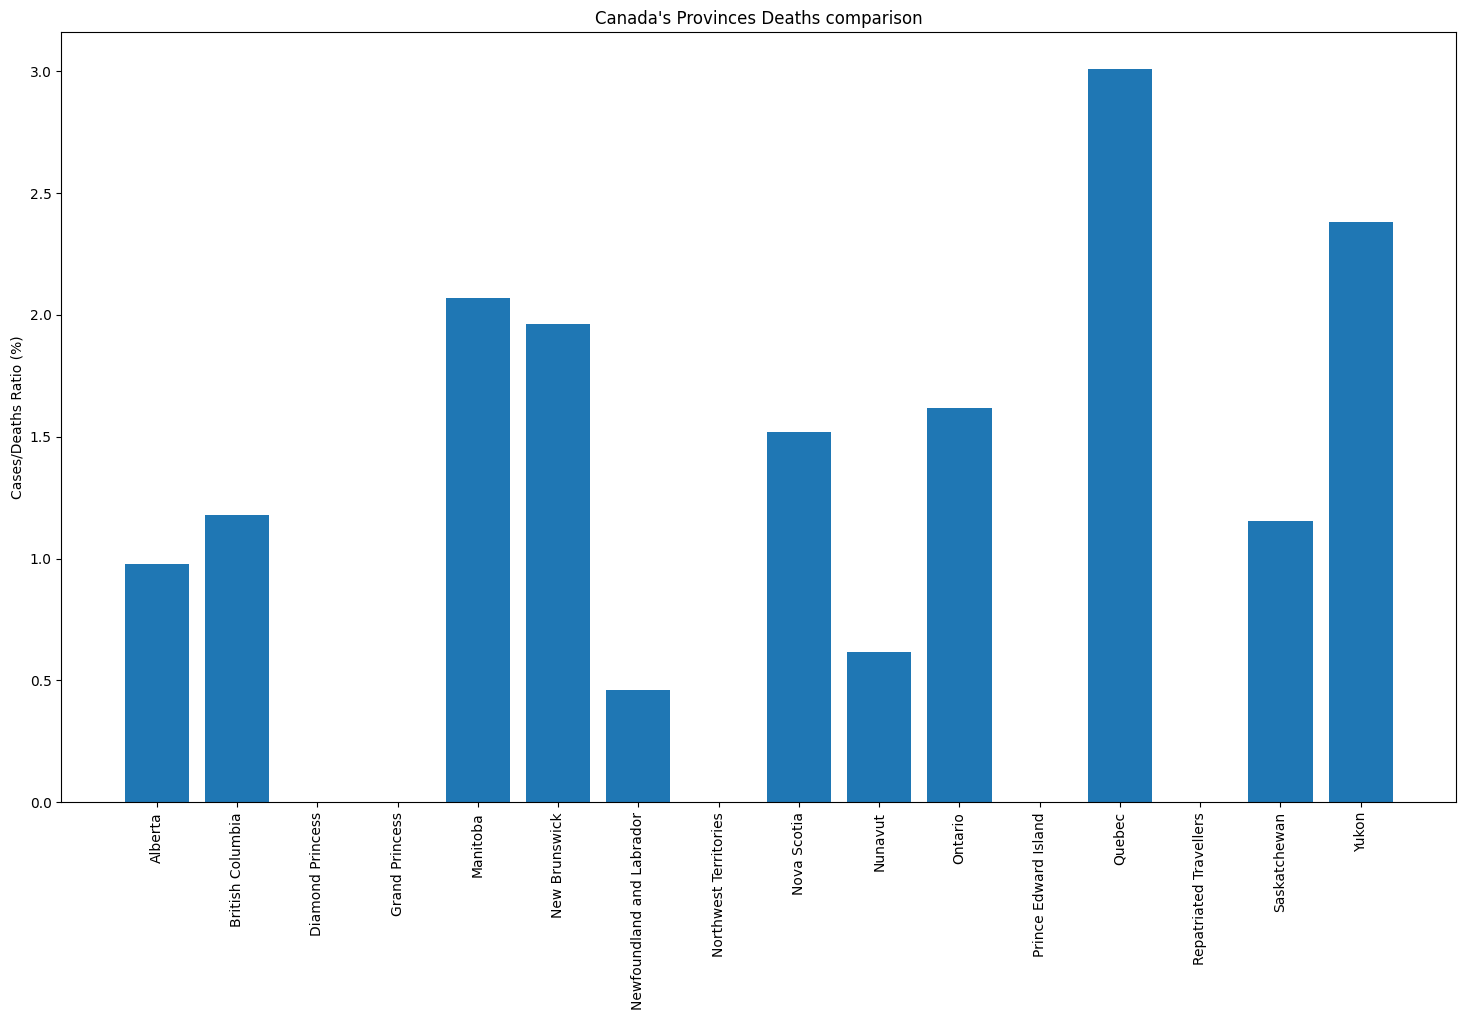

In [ ]:
def compare_death_rates_of_provinces_of_a_country(df, country):
    pass
canada_deaths_data = deaths_data_copy[deaths_data_copy["Country/Region"] == "Canada"]
canada_total_cases = confirmed_data_Copy[confirmed_data_Copy["Country/Region"] == "Canada"]
canada_total_cases_till_now = canada_total_cases[ ["Province/State", canada_total_cases.columns[-1]]].set_index("Province/State")
canada_total_deaths_till_now = canada_deaths_data[["Province/State", canada_total_cases.columns[-1]]].set_index("Province/State")

divided = canada_total_deaths_till_now / canada_total_cases_till_now * 100
divided.rename(columns={"5/29/21":"Death Ratio %"}, inplace=True)
divided.replace(np.inf, 0.0, inplace=True)
divided = divided.reset_index()
canada_total_deaths_till_now =  pd.merge(canada_total_deaths_till_now, divided, on="Province/State", how="left")
canada_total_deaths_till_now.rename(columns={"5/29/21":"Total deaths till now"}, inplace= True)
canada_total_deaths_till_now

plt.figure(figsize=(18,10))
plt.title("Canada's Provinces Deaths comparison")
plt.bar(canada_total_deaths_till_now["Province/State"], canada_total_deaths_till_now["Death Ratio %"])
plt.ylabel("Cases/Deaths Ratio (%)")
plt.xticks(rotation=90)
plt.savefig("Canada's Provinces Deaths comparison.png")
plt.show()

DATA TRANSFORMATION

Q6.1: Transform the 'deaths' dataset from wide format (where each column represents a date) to long format, where each row represents a single date, ensuring that the date column is in datetime format. How would this transformation be executed?

In [75]:
def transform_to_long_format(df, id, value_variables):
  transformed_df = pd.melt(df, id_vars=["Country/Region","Province/State","Lat","Long"], value_vars= value_variables )
  transformed_df.rename(columns={0:"Date", "value" : "cases_cumulative", "variable":"Date"}, inplace=True)
  transformed_df["Date"] = pd.to_datetime(transformed_df["Date"], format="%m/%d/%y")
  transformed_df.dropna(inplace=True)
  transformed_df["cases_cumulative"] = transformed_df["cases_cumulative"].astype(int)
  return transformed_df

date_columns= deaths_data_copy.columns[4:]
deaths_transformed = transform_to_long_format(deaths_data_copy, ["Country/Region","Province/State","Lat","Long"], date_columns)
confirmed_transformed = transform_to_long_format(confirmed_data_Copy, ["Country/Region","Province/State","Lat","Long"], date_columns)
recovered_transformed = transform_to_long_format(recovered_data_copy, ["Country/Region","Province/State","Lat","Long"], date_columns)


Q6.2: What is the total number of deaths reported per country up to the current date?

In [ ]:
deaths_groupedby_country_and_date = deaths_transformed.groupby(["Country/Region", "Date"]).sum(numeric_only=True).reset_index()
total_deaths = deaths_groupedby_country_and_date[deaths_groupedby_country_and_date["Date"] == "2021-05-29"]
total_deaths = total_deaths.sort_values(by="cases_cumulative", ascending = False)

plt.figure(figsize=(28,15))
plt.title("Total deaths per country")
x = total_deaths["Country/Region"]
y = total_deaths["cases_cumulative"]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.savefig("Total deaths per country.png")
plt.show()


,Country/Region,Date,cases_cumulative
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0
3,Afghanistan,2020-01-25,0
4,Afghanistan,2020-01-26,0
5,Afghanistan,2020-01-27,0
6,Afghanistan,2020-01-28,0
7,Afghanistan,2020-01-29,0
8,Afghanistan,2020-01-30,0
9,Afghanistan,2020-01-31,0


Q6.4: How have the total deaths evolved over time in the United States?

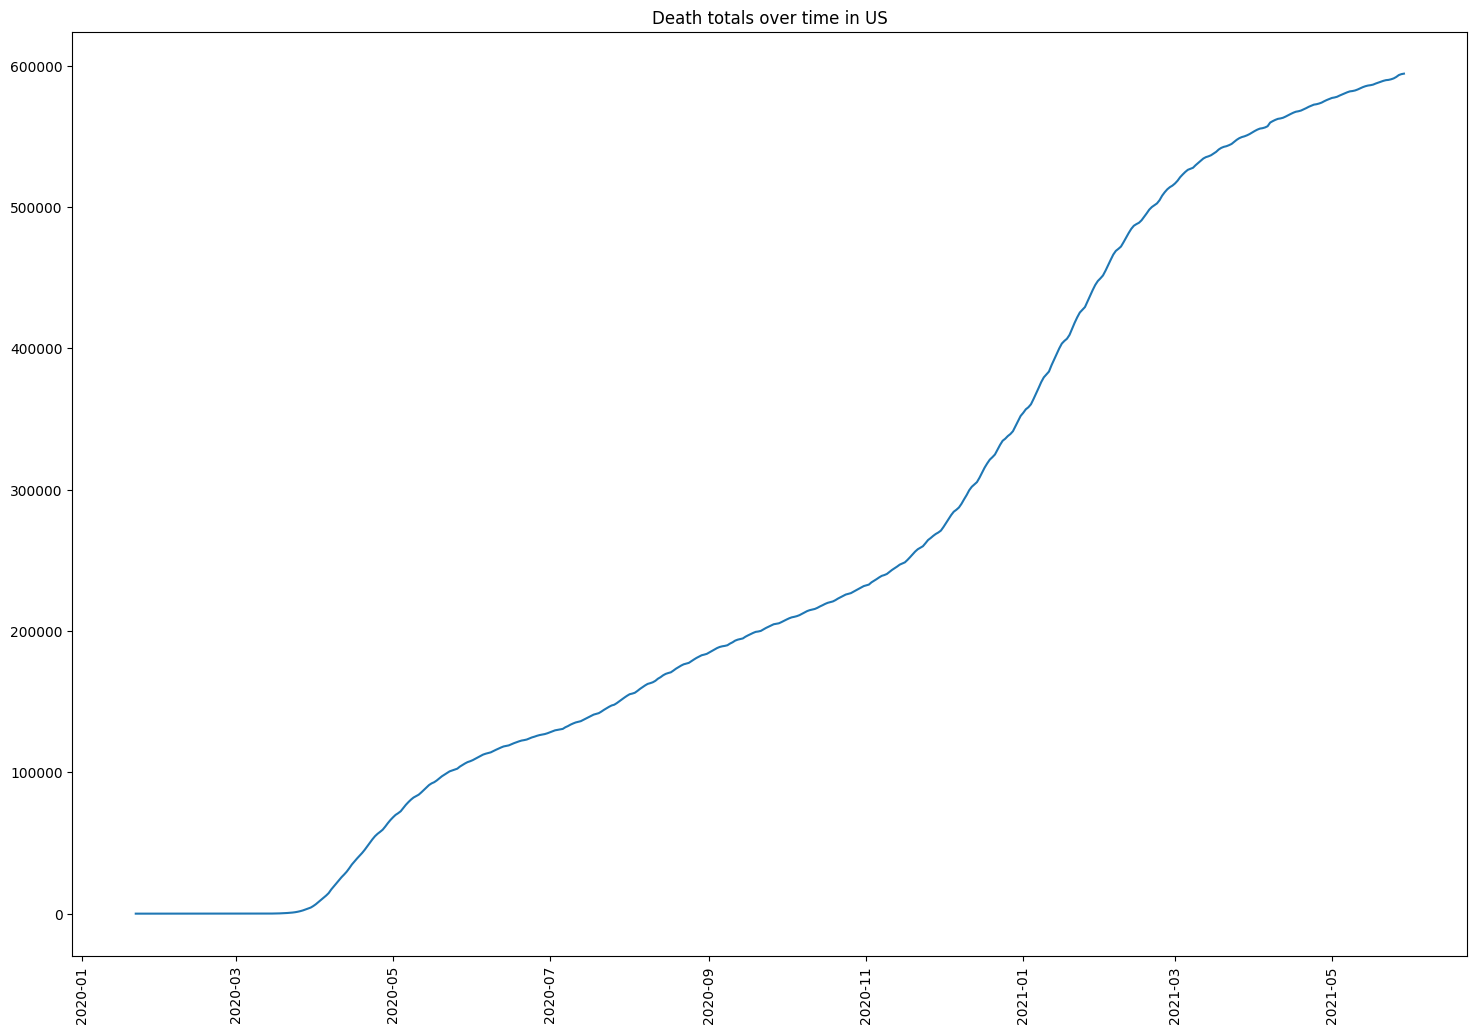

In [ ]:
US_deaths_cumulative = deaths_groupedby_country_and_date[deaths_groupedby_country_and_date["Country/Region"] == "US"]
US_deaths_cumulative

plt.figure(figsize=(18,12))
plt.title("Death totals over time in US")
x= US_deaths_cumulative["Date"]
y= US_deaths_cumulative["cases_cumulative"]
plt.plot(x,y)
plt.xticks(rotation=90)
plt.savefig("Death totals over time in US.png")
plt.show()


Q6.3: What are the top 5 countries with the highest average daily deaths?

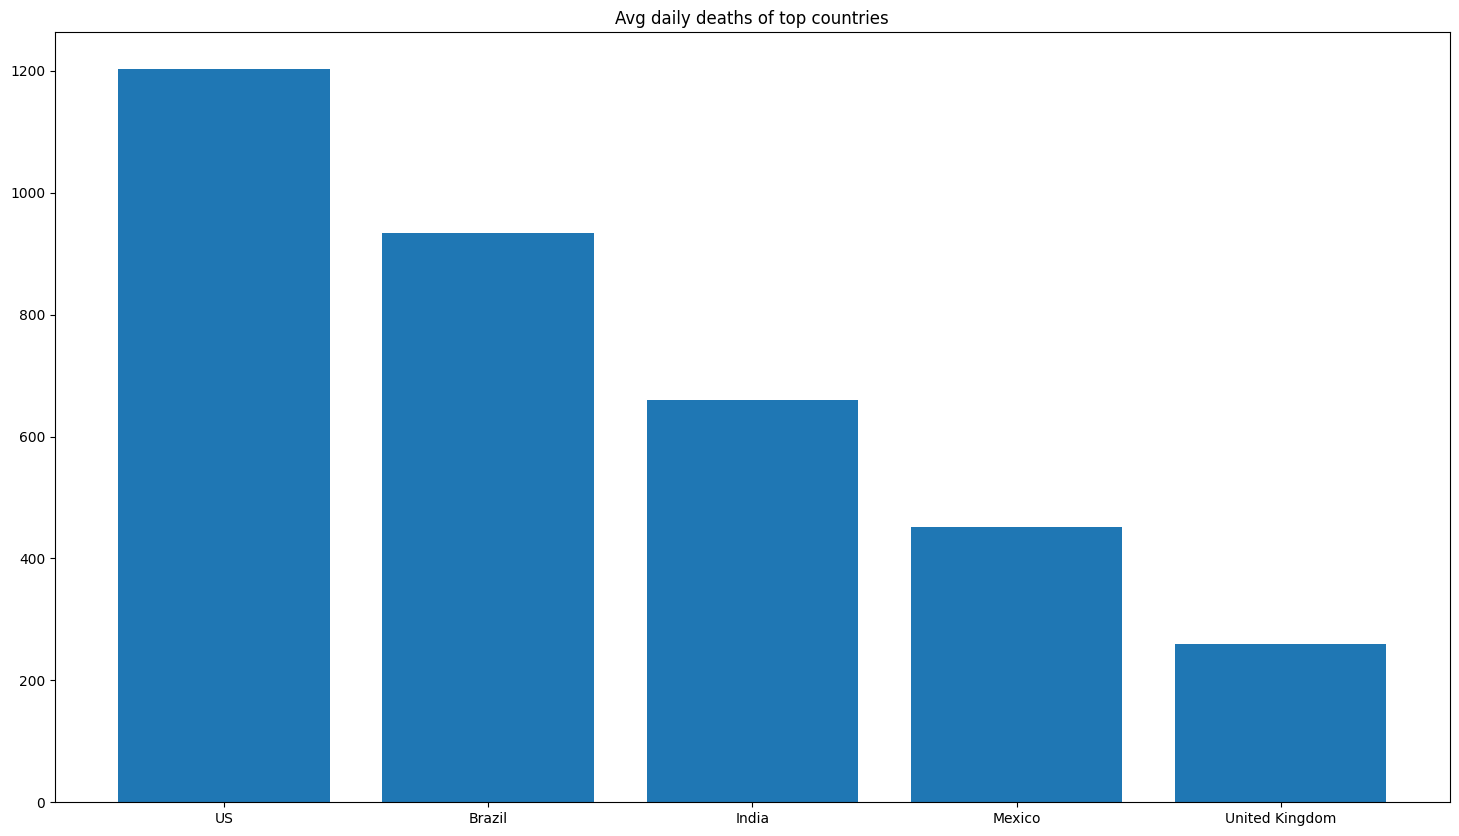

In [ ]:
# deaths_data_copy.dropna(inplace=True)
daily_deaths_of_countries = deaths_data_copy.groupby("Country/Region").sum(numeric_only=True)
daily_deaths_of_countries = daily_deaths_of_countries - daily_deaths_of_countries.shift(axis=1)
daily_deaths_of_countries.fillna(0, inplace=True)
daily_deaths_of_countries = daily_deaths_of_countries
daily_deaths_of_countries = daily_deaths_of_countries.transpose()
daily_deaths_of_countries.reset_index(inplace=True)
daily_deaths_of_countries.rename(columns={0:"Date"}, inplace=True)
avg_daily_deaths = daily_deaths_of_countries.mean(numeric_only=True).sort_values(ascending=False)
top_five_avg_daily_deaths = avg_daily_deaths.head().rename("daily_deaths")
top_five_avg_daily_deaths

plt.figure(figsize=(18,10))
plt.title("Avg daily deaths of top countries")
x = top_five_avg_daily_deaths.index
y= top_five_avg_daily_deaths.values
plt.bar(x,y)
plt.savefig("Avg daily deaths of top countries.png")
plt.show()

Question 7: Data Merging

Q7.1: How would you merge the transformed datasets of confirmed cases, deaths, and recoveries on the 'Country/Region' and 'Date' columns to create a comprehensive view of the pandemic's impact?

In [77]:
confirmed_transformed["Lat"] = confirmed_transformed["Lat"].astype(str)
confirmed_transformed["Long"] = confirmed_transformed["Long"].astype(str)

merged = pd.merge(confirmed_transformed, recovered_transformed, on=["Country/Region","Date","Province/State"], how="left" , suffixes=["_confirmed","_recovered"])

all_merged = pd.merge(merged, deaths_transformed, on=["Country/Region","Date","Province/State"], how="left", suffixes=["","_deaths"])
all_merged[(all_merged["Country/Region"] == "France") & (all_merged["Date"]== "2021-05-29")]
all_merged[all_merged["Lat"] != all_merged["Lat_confirmed"]]
all_merged.drop(columns=["Lat","Lat_recovered","Long","Long_recovered"], inplace=True)
all_merged.rename(columns={"Lat_confirmed":"Lat", "Long_confirmed":"Long", "cases_cumulative": "cases_cumulative_deaths"}, inplace=True)
all_merged.isnull().sum()


,0
Country/Region,0
Province/State,0
Lat,0
Long,0
Date,0
cases_cumulative_confirmed,0
cases_cumulative_recovered,7904
cases_cumulative_deaths,0


Q7.2: Analyze the monthly sum of confirmed cases, deaths, and recoveries for countries to understand the progression of the pandemic.[From the merged dataset]

In [ ]:
grouped_by = all_merged.groupby(["Country/Region","Date"]).sum().reset_index()
grouped_by["month"] = grouped_by["Date"].dt.month_name() + ", " + grouped_by["Date"].dt.strftime("%Y")
grouped_by.head(40)
grouped_by_month = grouped_by.groupby(["Country/Region", "month"]).max(numeric_only=True).reset_index()
worldwide_progression= grouped_by_month.groupby("month").sum(numeric_only=True).sort_values(by="cases_cumulative_confirmed")
worldwide_progression

plt.figure(figsize=(18,25))
plt.title("Monthly progression of Covid World-wide")
x= worldwide_progression.index
y1= worldwide_progression["cases_cumulative_confirmed"]
y2= worldwide_progression["cases_cumulative_recovered"]
y3= worldwide_progression["cases_cumulative_deaths"]
plt.plot(x,y1, label="Confirmed cases", color="purple")
plt.plot(x,y3, label="Deaths cases", color="red")
plt.plot(x,y2, label="Recovered cases", color="green")
plt.legend()
plt.xticks(rotation=90)
plt.savefig("Monthly progression of Covid World-wide.png")
plt.show()

,cases_cumulative_confirmed,cases_cumulative_recovered,cases_cumulative_deaths
month,,,
"January, 2020",9927,225.0,213
"February, 2020",86013,39775.0,2942
"March, 2020",875802,176259.0,44532
"April, 2020",3280089,992222.0,237421
"May, 2020",6188291,2587964.0,376667
"June, 2020",10457929,5283391.0,508187
"July, 2020",17604799,10285334.0,675532
"August, 2020",25510392,16709919.0,851633
"September, 2020",34011737,23542723.0,1015020


Q 7.3: Redo the analysis in Question 7.2 for the United States, Italy, and Brazil.

In [ ]:
def plot_monthly_progression_of_countries(countries, df):
    data = [("cases_cumulative_confirmed","purple"), ("cases_cumulative_recovered","green"), ("cases_cumulative_deaths","red")]
    for country in countries:
      monthly_progression = df[df["Country/Region"] == country].sort_values(by="cases_cumulative_confirmed")
      monthly_progression.replace(to_replace=0, method="ffill", inplace=True)
      plt.figure(figsize=(18,10))
      plt.title(country + " monthly progression of Covid")
      x = monthly_progression["month"]
      for entry in data:
        y = monthly_progression[entry[0]]
        plt.plot(x,y, label=entry[0], color=entry[1])
      plt.legend()
      plt.xticks(rotation=90)
      plt.savefig(country + " monthly progression of Covid.png")
      plt.show()

countries = ["US","Italy","Brazil"]
plot_monthly_progression_of_countries(countries, grouped_by_month)


Question 8: Combined Data Analysis

Q8.1: For the combined dataset, identify the three countries with the highest average death rates (deaths/confirmed cases) throughout 2020. What might this indicate about the pandemic's impact in these countries?

<ipython-input-126-d4e5c620811e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_totals_on_the_last_day_of_2020["death_rate%"] = countries_totals_on_the_last_day_of_2020["cases_cumulative_deaths"] / countries_totals_on_the_last_day_of_2020["cases_cumulative_confirmed"] * 100
<ipython-input-126-d4e5c620811e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_totals_on_the_last_day_of_2020.sort_values(by="death_rate%", ascending=False, inplace=True)


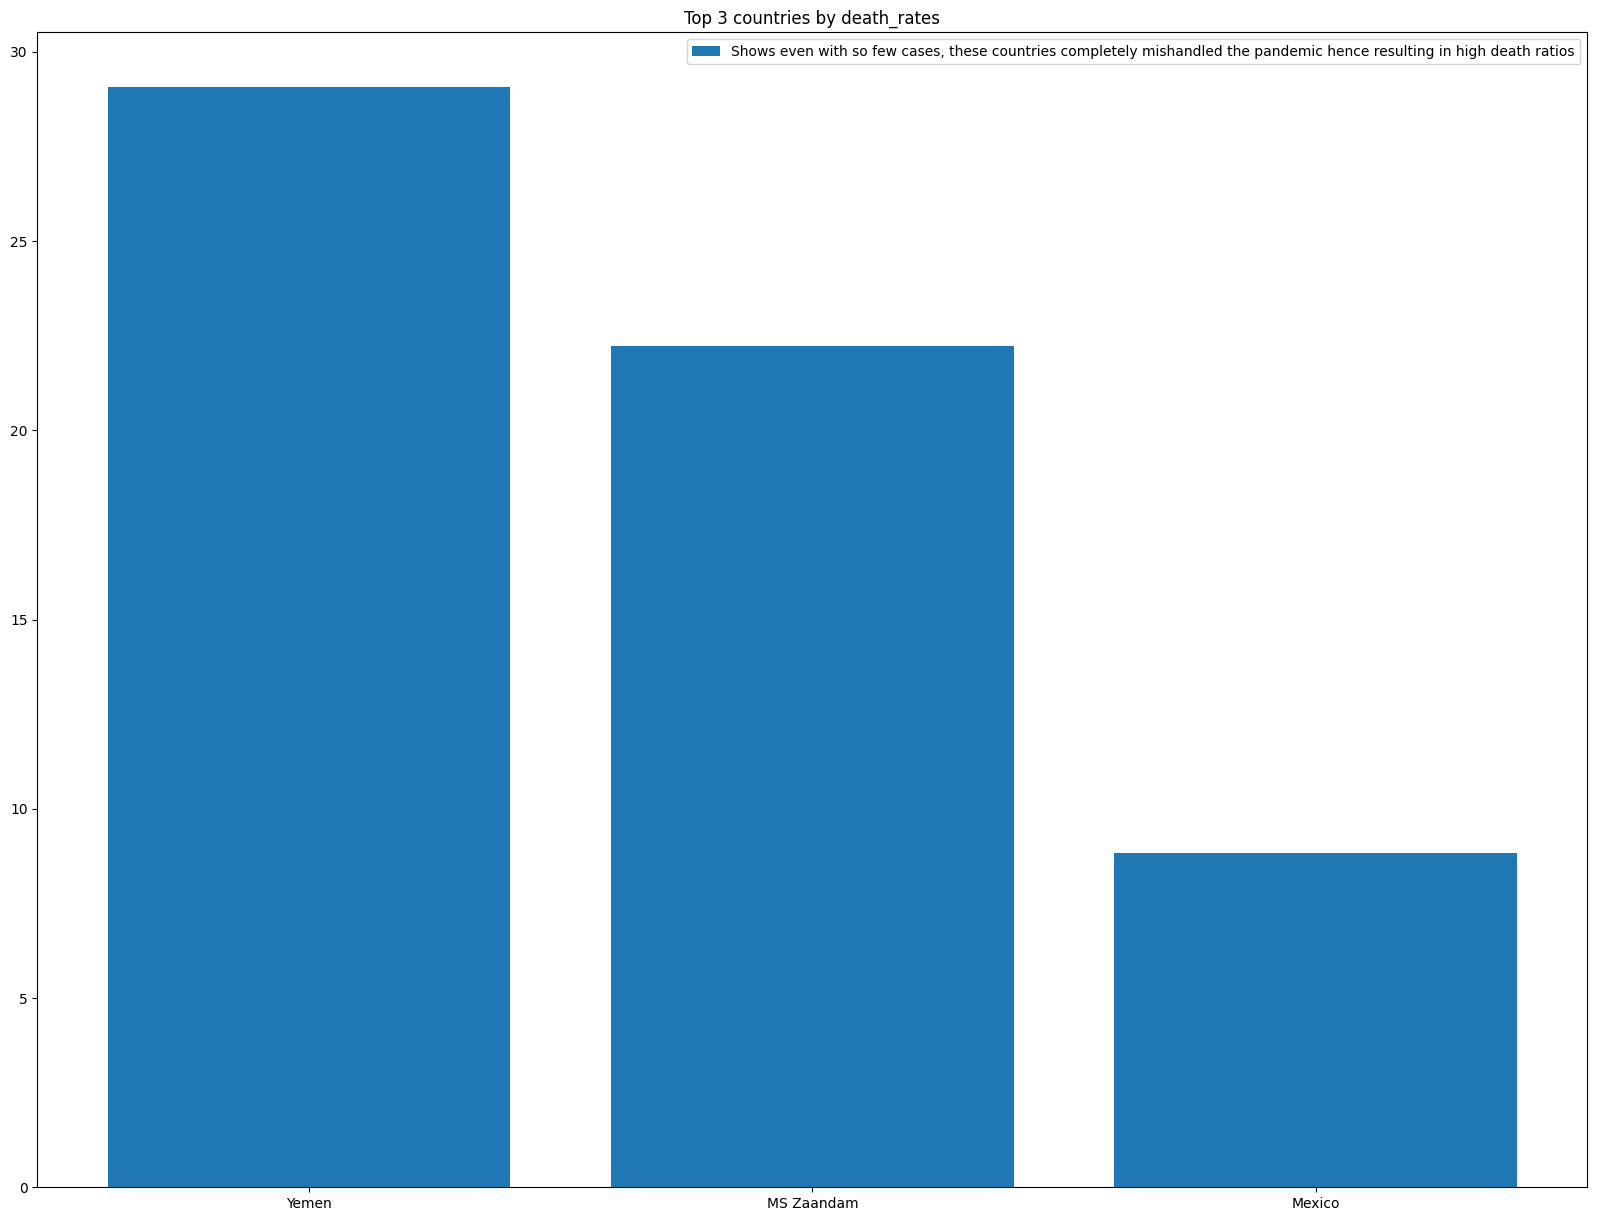

In [126]:
all_merged_grouped_by_country_and_date = all_merged.groupby(["Country/Region","Date"]).sum(numeric_only=True).reset_index()
all_merged_grouped_by_country_and_date["month"] = all_merged_grouped_by_country_and_date["Date"].dt.month_name() + "," + all_merged_grouped_by_country_and_date["Date"].dt.strftime("%Y")
grouped_by_month = all_merged_grouped_by_country_and_date.groupby(["Country/Region", "month"]).max(numeric_only=True).reset_index()

countries_totals_on_the_last_day_of_2020 = grouped_by_month[grouped_by_month["month"] == "December,2020"]
countries_totals_on_the_last_day_of_2020["death_rate%"] = countries_totals_on_the_last_day_of_2020["cases_cumulative_deaths"] / countries_totals_on_the_last_day_of_2020["cases_cumulative_confirmed"] * 100
countries_totals_on_the_last_day_of_2020.sort_values(by="death_rate%", ascending=False, inplace=True)

plt.figure(figsize=(20,15))
plt.title("Top 3 countries by death_rates")
x= countries_totals_on_the_last_day_of_2020.head(3)["Country/Region"]
y= countries_totals_on_the_last_day_of_2020.head(3)["death_rate%"]
plt.bar(x,y, label="Shows even with so few cases, these countries completely mishandled the pandemic hence resulting in high death ratios")
plt.legend()
plt.savefig("Top 3 countries by death_rates.png")
plt.show()

Q8.2: Using the merged dataset, compare the total number of recoveries to the total number of deaths in South Africa. What can this tell us about the outcomes of COVID-19 cases in the country?

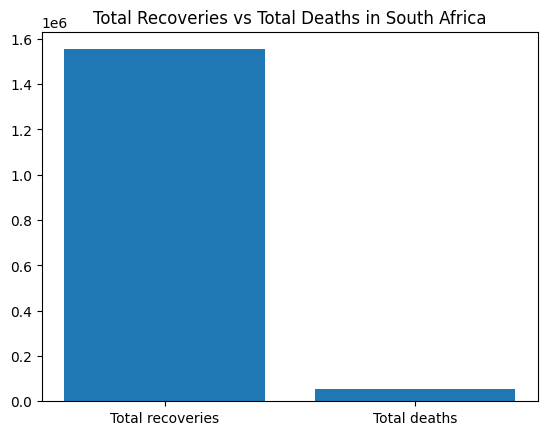

In [127]:
combined_data_south_africa = grouped_by_month[grouped_by_month["Country/Region"]== "South Africa"]
total_cases_in_south_africa = combined_data_south_africa.max().loc["cases_cumulative_confirmed"]
total_recoveries_in_south_africa = combined_data_south_africa.max().loc["cases_cumulative_recovered"]
total_deaths_in_south_africa = combined_data_south_africa.max().loc["cases_cumulative_deaths"]
x= ["Total recoveries","Total deaths"]
y=[total_recoveries_in_south_africa, total_deaths_in_south_africa]

plt.title("Total Recoveries vs Total Deaths in South Africa")
plt.bar(x,y)
plt.savefig("Total Recoveries vs Total Deaths in South Africa.png")
plt.show()


Q8.3: Analyze the ratio of recoveries to confirmed cases for the United States monthly from March 2020 to May 2021. Which month experienced the highest recovery ratio, and what could be the potential reasons?

<ipython-input-138-1d7135ec4a66>:6: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  US_data.replace(0,method ="ffill", inplace=True)


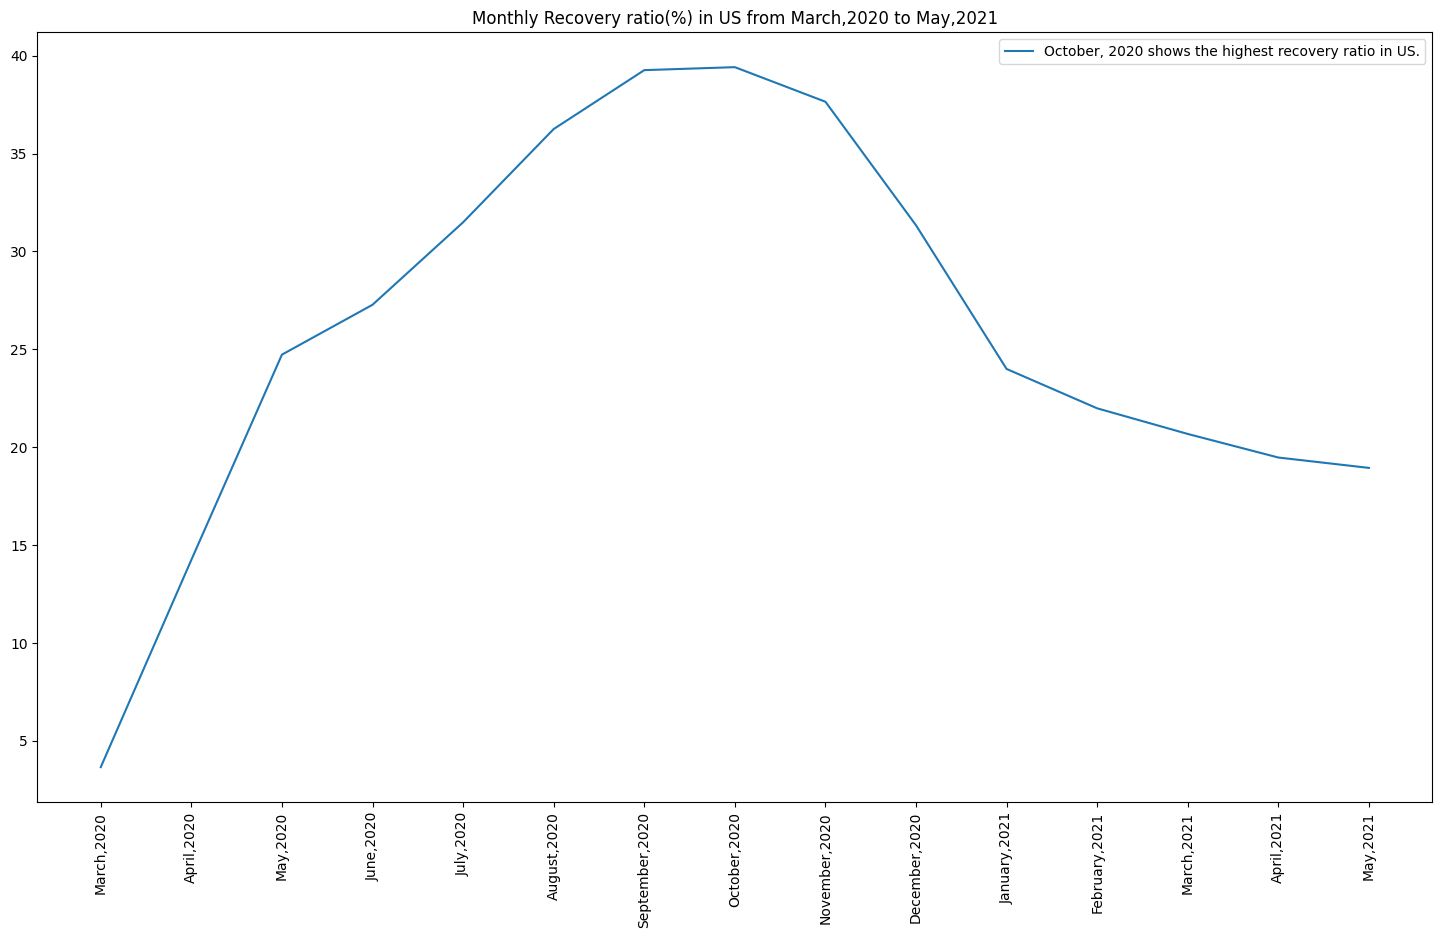

In [138]:
US_data = grouped_by_month[grouped_by_month["Country/Region"] == "US"].sort_values(by="cases_cumulative_confirmed")
#previous code
starting_month_index = US_data[US_data["month"]=="March,2020"].index[0]
ending_month_index = US_data[US_data["month"]=="May,2021"].index[0]

US_data.replace(0,method ="ffill", inplace=True)
US_data = US_data.loc[starting_month_index:ending_month_index]
US_data["recovery_ratio"] = US_data["cases_cumulative_recovered"] / US_data["cases_cumulative_confirmed"] * 100
US_data

plt.figure(figsize=(18,10))
plt.title("Monthly Recovery ratio(%) in US from March,2020 to May,2021")
x= US_data["month"]
y = US_data["recovery_ratio"]
plt.plot(x, y, label = "October, 2020 shows the highest recovery ratio in US.")
plt.xticks(rotation=90)
plt.legend()
plt.savefig("Monthly Recovery ratio(%) in US from March,2020 to May,2021.png")
plt.show()